## tool.py  用于回测 以及 因子有效性的测试

#### 因子有效性检验框架
考虑到可能存在的情形是，当天发出买卖信号持有至收盘，
计算IC为分钟信号与分钟收盘价到当日收盘价收益的相关系数
只考虑量价因子

In [1]:
from main import *

In [2]:
ETF_minquotes = pd.read_parquet(f'ETF_minquotes.parquet')
F588080 = ETF_minquotes.loc[ETF_minquotes['windcode'] == '588080.SH']

In [3]:
stop_loss_ratio = 0.02  # 2%止损比例
periods = [('09:59','10:59'),('13:29','14:29')]  # 信号生成时间段
rolling_rank = True  # 是否使用滚动排序作为分位数的计算方式
rolling_window = 240  # 滚动排序窗口大小
upper_bound = 0.8  # 分位数上界
lower_bound = 0.2  # 分位数下界
stop_bound = 0.5  # 止损分位数
factor_name = 'close'

In [4]:
data = F588080.copy()
data['%H:%M'] = data.index.strftime('%H:%M')

In [77]:
data[f'{factor_name}_upper_bound'] = data[factor_name].rolling(rolling_window,min_periods = 240).quantile(upper_bound)
data[f'{factor_name}_lower_bound'] = data[factor_name].rolling(rolling_window,min_periods = 240).quantile(lower_bound)
data[f'{factor_name}_stop_bound'] = data[factor_name].rolling(rolling_window,min_periods = 240).quantile(stop_bound)
if not rolling_rank: # 取过去几日的分位数固定当日的上下界
    data[f'{factor_name}_upper_bound'].shift().groupby(data[f'{factor_name}_upper_bound'].index.date).transform(lambda x: x.iloc[0])  
    data[f'{factor_name}_lower_bound'].shift().groupby(data[f'{factor_name}_lower_bound'].index.date).transform(lambda x: x.iloc[0])
    data[f'{factor_name}_stop_bound'].shift().groupby(data[f'{factor_name}_stop_bound'].index.date).transform(lambda x: x.iloc[0])


In [78]:
data['signal'] = 0
data.loc[data[factor_name] > data[f'{factor_name}_upper_bound'], 'signal'] = 1    # 买入信号
data.loc[data[factor_name] < data[f'{factor_name}_lower_bound'], 'signal'] = -1   # 卖出信号

# 创建一个布尔掩码，初始值都为 False
mask = pd.Series(False, index=data.index)
# 遍历每个时间段
for start_time, end_time in periods:    # 为每个时间段内的时间点设置掩码为 True
    mask = mask | ((data.loc[:,'%H:%M'] >= start_time) & (data.loc[:,'%H:%M']  <= end_time))
data.loc[~mask, 'signal'] = 0

In [9]:
temp = data[240:480]

In [5]:
def get_position(temp):
    OpenTime = temp.loc[temp['signal']!=0,'signal']
    OpenTime = OpenTime.idxmin() if len(OpenTime) != 0 else temp['signal'].idxmin()# 开仓时刻（下一时刻的open价买入）
    direction = temp.loc[OpenTime,'signal'] #确定一开始的买入卖出方向 1表示买入，-1表示卖出

    temp.loc[:,'Openpos'] = (temp.index>OpenTime)  # 判断是否已开仓
    temp.loc[:,'Openprice'] = temp.loc[temp['Openpos'],'open'].iloc[0]  # 记录开仓价格
    temp.loc[:,'Holdret'] = temp['close']/temp['Openprice']-1  # 计算持仓收益
    temp.loc[:,'Stoploss'] = temp['Holdret']>-stop_loss_ratio  # 判断是否触发收益止损比例
    if direction == 1:  #这里还需要乘上有效时间段
        temp.loc[:,'Stopsignal'] = temp[factor_name] >= temp[f'{factor_name}_upper_stop_bound']  # 判断是否触发信号止损分位数
    elif direction == -1:
        temp.loc[:,'Stopsignal'] = temp[factor_name] <= temp[f'{factor_name}_lower_stop_bound']  # 判断是否触发信号止损分位数
    else:
        temp.loc[:,'Stopsignal'] = False
    mask = pd.Series(False, index=temp.index)
    for start_time, end_time in periods:    # 为每个时间段内的时间点设置掩码为 True
        mask = mask | ((temp.loc[:,'%H:%M'] >= start_time) & (temp.loc[:,'%H:%M']  <= end_time))
    temp.loc[~mask, 'Stopsignal'] = True       # 将不在时间段内的信号设置为0
    
    temp.loc[:,'position'] = direction*temp['Openpos'] * temp['Stoploss'] * temp['Stopsignal']  # 计算持仓信号

    CloseTime = temp.loc[(temp['position']==0)&(temp['position'].shift()==direction),'position']  # 记录平仓时刻
    if len(CloseTime) != 0:
        CloseTime = CloseTime.idxmin()  # 显示平仓时刻
        temp.loc[CloseTime,'position'] = direction  # 平仓时刻后持仓信号为0
        temp.loc[temp.index>CloseTime,'position'] = 0
    return temp

In [11]:
data = FactorIC_.minquotes['F588080']
factor_name = 'ADL_4hour'
data['%H:%M'] = data.index.strftime('%H:%M')
upper_stop_bound = 0.5
lower_stop_bound = 0.5
rolling_window = 480
upper_bound = 0.8
lower_bound = 0.2
stop_loss_ratio = 0.02
periods = [('12:59','14:55')]
data[f'{factor_name}_upper_bound'] = data[factor_name].rolling(rolling_window,min_periods = 240).quantile(upper_bound)
data[f'{factor_name}_lower_bound'] = data[factor_name].rolling(rolling_window,min_periods = 240).quantile(lower_bound)
data[f'{factor_name}_upper_stop_bound'] = data[factor_name].rolling(rolling_window,min_periods = 240).quantile(upper_stop_bound)
data[f'{factor_name}_lower_stop_bound'] = data[factor_name].rolling(rolling_window,min_periods = 240).quantile(lower_stop_bound)

data['signal'] = 0
data.loc[data[factor_name] > data[f'{factor_name}_upper_bound'], 'signal'] = 1    # 买入信号
data.loc[data[factor_name] < data[f'{factor_name}_lower_bound'], 'signal'] = -1   # 卖出信号

# 创建一个布尔掩码，初始值都为 False
mask = pd.Series(False, index=data.index)
for start_time, end_time in periods:    # 为每个时间段内的时间点设置掩码为 True
    mask = mask | ((data.loc[:,'%H:%M'] >= start_time) & (data.loc[:,'%H:%M']  <= end_time))
data.loc[~mask, 'signal'] = 0       # 将不在时间段内的信号设置为0
data = data.groupby(data.index.date).apply(get_position).droplevel(0)  # 每日只保留第一个信号


In [7]:
for d in np.unique(data.index.date):
    temp = data.loc[data.index.date==d]
    get_position(temp)

IndexError: single positional indexer is out-of-bounds

In [8]:
OpenTime

Timestamp('2023-01-13 14:59:00')

In [10]:
temp.loc[temp['signal']!=0,'signal']

2023-02-07 14:59:00   -1
Name: signal, dtype: int64

In [ ]:
OpenTime = temp.loc[temp['signal']!=0,'signal']
OpenTime = OpenTime.idxmin() if len(OpenTime) != 0 else temp['signal'].idxmin()# 开仓时刻（下一时刻的open价买入）
direction = temp.loc[OpenTime,'signal'] #确定一开始的买入卖出方向 1表示买入，-1表示卖出

temp.loc[:,'Openpos'] = (temp.index>OpenTime)  # 判断是否已开仓
temp.loc[:,'Openprice'] = temp.loc[temp['Openpos'],'open'].iloc[0]  # 记录开仓价格
temp.loc[:,'Holdret'] = temp['close']/temp['Openprice']-1  # 计算持仓收益
temp.loc[:,'Stoploss'] = temp['Holdret']>-stop_loss_ratio  # 判断是否触发收益止损比例


IndexError: single positional indexer is out-of-bounds

In [17]:
temp.loc[temp['Openpos'],'open']

Series([], Name: open, dtype: float64)

平均持仓时间: 122.295172 分钟
胜率：0.485477
年化收益率：0.827450
年化夏普比率：4.593506


direction  holdingmins      dailyret
2022-02-14          0            0  0.000000e+00
2022-02-15          1          210  1.476620e-02
2022-02-16          1          120 -8.090615e-04
2022-02-17          1            4 -3.231018e-03
2022-02-18         -1          209 -4.930124e-03
...               ...          ...           ...
2025-02-05          1          128  1.998401e-15
2025-02-06          1          210  2.073050e-02
2025-02-07          1          139  9.578544e-04
2025-02-10          1           90  2.835539e-03
2025-02-11          1           34 -9.425071e-03

[725 rows x 3 columns]

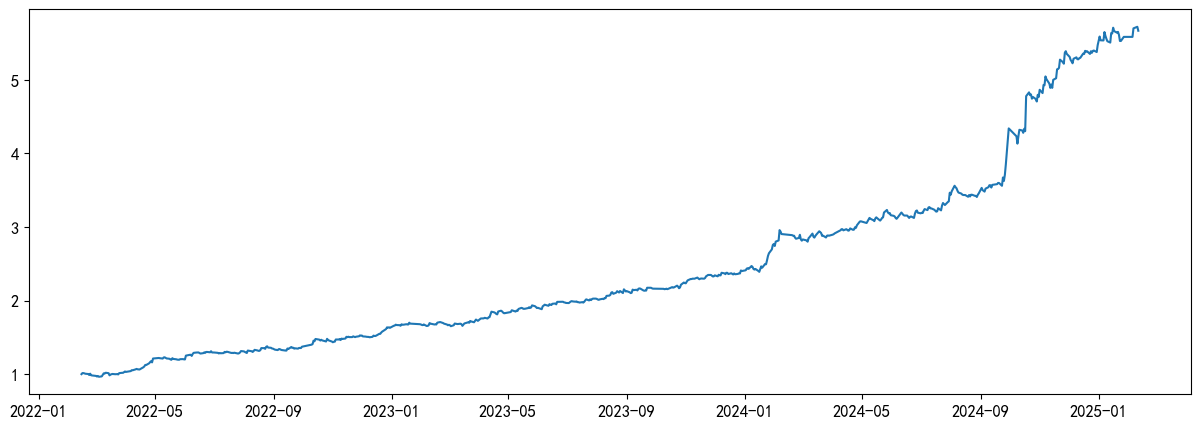

In [ ]:
strategy1 = ETFIntradayStrategy(
    data=data,
    factor_name = factor_name,
    direction = 1,
    periods = [('09:59','10:59'),('13:29','14:29')],
    rolling_rank = True,
    rolling_window = 480,
    upper_bound = 0.8,
    lower_bound = 0.2,
    stop_bound = 0.5,
    stop_loss_ratio = 0.02
)
strategy1.get_performance()

In [ ]:
def generate_position(self):
    """生成持仓（1表示持有多仓，-1表示持有空仓）"""
    # 生成信号
    signals = pd.DataFrame(0, index=data.index, columns=['signal'])
    signals.loc[ data[self.factor_name] > self.BuyBound, 'signal'] = 1    # 买入信号
    signals.loc[self.data[self.factor_name] < self.SellBound, 'signal'] = -1   # 卖出信号
    # 限制开仓时间
    signals.loc[signals.index.strftime('%H:%M') < self.LimitOpenTime] = 0
    signals['pos'] = signals['signal'].groupby(signals.index.date).apply(self.get_position).values
    return signals

def get_position(self,temp):
    """根据信号生成仓位"""
    temp = temp.replace(0,np.nan).ffill().replace(np.nan,0)  # 填充信号
    temp_diff = temp.diff()  # 之后是去找到每天开仓后那一段0的时间段，即为持仓期
    temp_diff.iloc[0] = temp.iloc[0]
    temp_diff = temp_diff.replace(0,np.nan).ffill().replace(np.nan,0)  # 填充信号   目的是保留那些为1或-1的值，其index的下一期则为持仓期
    position = pd.DataFrame(0, index=temp.index, columns=['position'])
    if len(temp_diff[temp_diff.abs()==1])>0:
        position.loc[temp_diff[temp_diff.abs().shift()==1].index] = temp_diff[temp_diff.abs()==1].iloc[0]
    # 可以考虑加一些限制条件，比如不能在最后30分钟开仓
    return position

## 一、连接wind数据库

In [1]:
from utils import *
from main import *
from WindPy import w
w.start()
w.isconnected()

Welcome to use Wind Quant API for Python (WindPy)!

COPYRIGHT (C) 2024 WIND INFORMATION CO., LTD. ALL RIGHTS RESERVED.
IN NO CIRCUMSTANCE SHALL WIND BE RESPONSIBLE FOR ANY DAMAGES OR LOSSES CAUSED BY USING WIND QUANT API FOR Python.


True

## 二、获取数据并保存至本地
起始日期 2022年2月14日-2025年2月11日

In [132]:
codes = ['588080.SH','159915.SZ']
fields = 'open,high,low,close,volume,amt,chg,pct_chg,'
begin_time = '2022-02-11 09:30:00'
end_time = '2025-02-11 15:00:00'
error, data = w.wsi(codes, fields, begin_time, end_time, "Fill=Previous",usedf=True)  #不复权 
### 剔除11:30和15:00的数据
data = data[(data.index.strftime("%H:%M")!="11:30") & (data.index.strftime("%H:%M")!="15:00")]
data.to_parquet('ETF_minquotes.parquet') 

## 三、因子构造

### 3.1 手动挖掘的信号因子

In [1]:
from utils import *

#### 3.1.1 成交量分布的高阶矩

F159915: volume_ratio: 持有至收盘 IC: 0.022, IR: 0.590
F159915: volume_kurt_10min: 持有至收盘 IC: -0.004, IR: -0.092
F159915: volume_kurt_1hour: 持有至收盘 IC: 0.007, IR: 0.278
F159915: volume_kurt_4hour: 持有至收盘 IC: -0.044, IR: -1.228
F159915: volume_kurt_1hour_4hour: 持有至收盘 IC: 0.021, IR: 0.593
F159915: volume_skew_10min: 持有至收盘 IC: -0.004, IR: -0.111
F159915: volume_skew_1hour: 持有至收盘 IC: 0.010, IR: 0.337
F159915: volume_skew_4hour: 持有至收盘 IC: -0.032, IR: -0.936
F159915: volume_skew_1hour_4hour: 持有至收盘 IC: 0.024, IR: 0.580
F159915: volume_std_10min: 持有至收盘 IC: 0.023, IR: 0.629
F159915: volume_std_1hour: 持有至收盘 IC: 0.049, IR: 1.273
F159915: volume_std_4hour: 持有至收盘 IC: 0.044, IR: 1.561
F159915: volume_std_1hour_4hour: 持有至收盘 IC: 0.030, IR: 0.800
F588080: volume_ratio: 持有至收盘 IC: 0.029, IR: 0.874
F588080: volume_kurt_10min: 持有至收盘 IC: 0.000, IR: 0.009
F588080: volume_kurt_1hour: 持有至收盘 IC: -0.026, IR: -0.941
F588080: volume_kurt_4hour: 持有至收盘 IC: 0.014, IR: 0.749
F588080: volume_kurt_1hour_4hour: 持有至收盘 IC: -0.021,

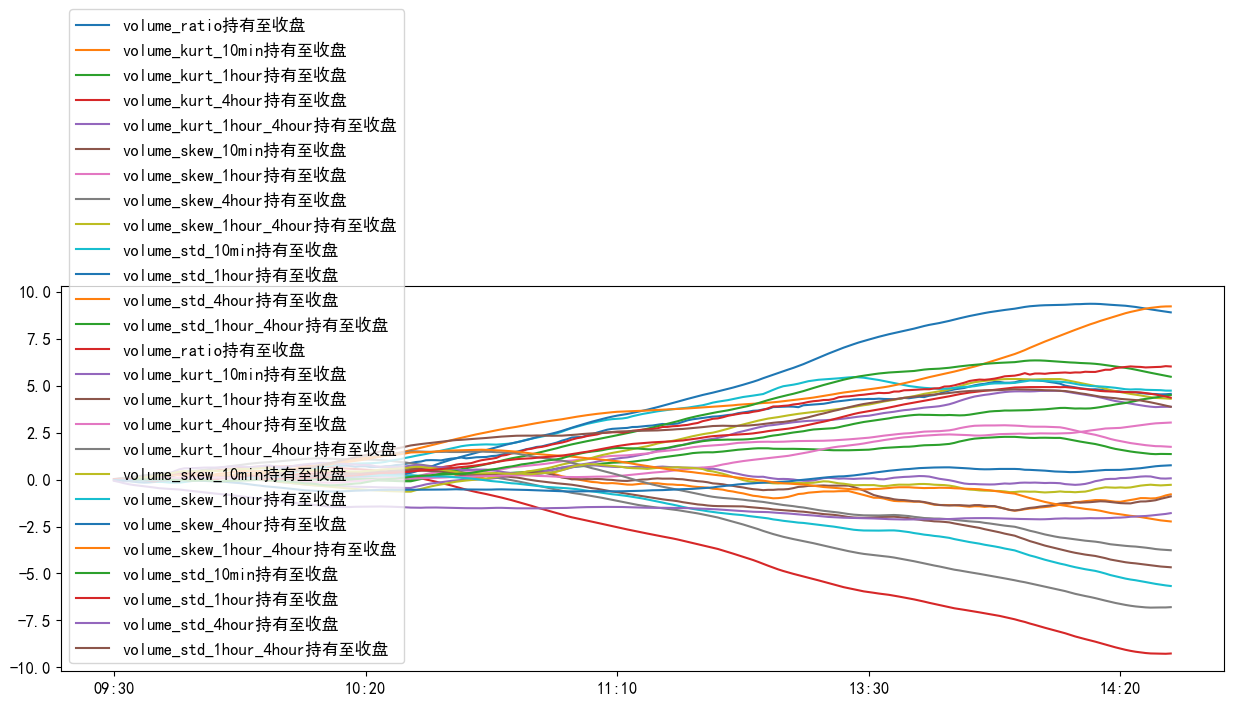

In [ ]:
factor_list = ['volume_ratio',
            'volume_ratio_kurt_10min','volume_ratio_kurt_1hour','volume_ratio_kurt_4hour','volume_ratio_kurt_1hour_4hour',
            'volume_ratio_skew_10min','volume_ratio_skew_1hour','volume_ratio_skew_4hour','volume_ratio_skew_1hour_4hour',
            'volume_ratio_std_10min','volume_ratio_std_1hour','volume_ratio_std_4hour','volume_ratio_std_1hour_4hour']
def volume_ratio_1_factor(minquote):
    minquote.loc[:,'volume_ratio'] = minquote['volume']/minquote['volume'].rolling(480,min_periods=60).mean()
    minquote.loc[:,'volume_ratio_kurt_10min'] = minquote['volume_ratio'].groupby(minquote.index.date).transform(lambda x:x.rolling(10,min_periods=5).kurt())
    minquote.loc[:,'volume_ratio_kurt_1hour'] = minquote['volume_ratio'].groupby(minquote.index.date).transform(lambda x:x.rolling(60,min_periods=30).kurt())
    minquote.loc[:,'volume_ratio_kurt_4hour'] = minquote['volume_ratio'].rolling(240,min_periods=120).kurt()
    minquote.loc[:,'volume_ratio_skew_10min'] = minquote['volume_ratio'].groupby(minquote.index.date).transform(lambda x:x.rolling(10,min_periods=5).skew())
    minquote.loc[:,'volume_ratio_skew_1hour'] = minquote['volume_ratio'].groupby(minquote.index.date).transform(lambda x:x.rolling(60,min_periods=30).skew())
    minquote.loc[:,'volume_ratio_skew_4hour'] = minquote['volume_ratio'].rolling(240,min_periods=120).skew()
    minquote.loc[:,'volume_ratio_std_10min'] = minquote['volume_ratio'].groupby(minquote.index.date).transform(lambda x:x.rolling(10,min_periods=5).std())
    minquote.loc[:,'volume_ratio_std_1hour'] = minquote['volume_ratio'].groupby(minquote.index.date).transform(lambda x:x.rolling(60,min_periods=30).std())
    minquote.loc[:,'volume_ratio_std_4hour'] = minquote['volume_ratio'].rolling(240,min_periods=120).std()
    
    minquote.loc[:,'volume_ratio_kurt_1hour_4hour'] = minquote['volume_kurt_1hour']/minquote['volume_kurt_4hour']
    minquote.loc[:,'volume_ratio_skew_1hour_4hour'] = minquote['volume_skew_1hour']/minquote['volume_skew_4hour']
    minquote.loc[:,'volume_ratio_std_1hour_4hour'] = minquote['volume_std_1hour']/minquote['volume_std_4hour']
    return minquote

FactorIC_ = FactorIC()
FactorIC_.CalcFactors(volume_ratio_1_factor)
result1 = FactorIC_.GetICResult(Fund_code='F159915',factor_list=factor_list)
result2 = FactorIC_.GetICResult(Fund_code='F588080',factor_list=factor_list)

d:\PythonProject1\.conda\Lib\site-packages\pandas\core\window\rolling.py:611: RuntimeWarning: All-NaN slice encountered
  return func(x, start, end, min_periods, *numba_args)
d:\PythonProject1\.conda\Lib\site-packages\pandas\core\window\rolling.py:611: RuntimeWarning: All-NaN slice encountered
  return func(x, start, end, min_periods, *numba_args)
d:\PythonProject1\.conda\Lib\site-packages\pandas\core\window\rolling.py:611: RuntimeWarning: All-NaN slice encountered
  return func(x, start, end, min_periods, *numba_args)
d:\PythonProject1\.conda\Lib\site-packages\pandas\core\window\rolling.py:611: RuntimeWarning: All-NaN slice encountered
  return func(x, start, end, min_periods, *numba_args)


F159915: volume_alpha_ratio: 持有至收盘 IC: 0.014, IR: 0.428
F159915: volume_alpha_kurt_10min: 持有至收盘 IC: 0.002, IR: 0.042
F159915: volume_alpha_kurt_1hour: 持有至收盘 IC: 0.012, IR: 0.383
F159915: volume_alpha_kurt_4hour: 持有至收盘 IC: -0.003, IR: -0.114
F159915: volume_alpha_kurt_1hour_4hour: 持有至收盘 IC: 0.006, IR: 0.281
F159915: volume_alpha_skew_10min: 持有至收盘 IC: -0.001, IR: -0.014
F159915: volume_alpha_skew_1hour: 持有至收盘 IC: 0.009, IR: 0.229
F159915: volume_alpha_skew_4hour: 持有至收盘 IC: 0.003, IR: 0.109
F159915: volume_alpha_skew_1hour_4hour: 持有至收盘 IC: -0.005, IR: -0.205
F159915: volume_alpha_std_10min: 持有至收盘 IC: 0.016, IR: 0.601
F159915: volume_alpha_std_1hour: 持有至收盘 IC: 0.025, IR: 0.812
F159915: volume_alpha_std_4hour: 持有至收盘 IC: 0.011, IR: 1.171
F159915: volume_alpha_std_1hour_4hour: 持有至收盘 IC: -0.000, IR: -0.003
F588080: volume_alpha_ratio: 持有至收盘 IC: 0.024, IR: 0.749
F588080: volume_alpha_kurt_10min: 持有至收盘 IC: -0.004, IR: -0.114
F588080: volume_alpha_kurt_1hour: 持有至收盘 IC: -0.033, IR: -0.834
F588080:

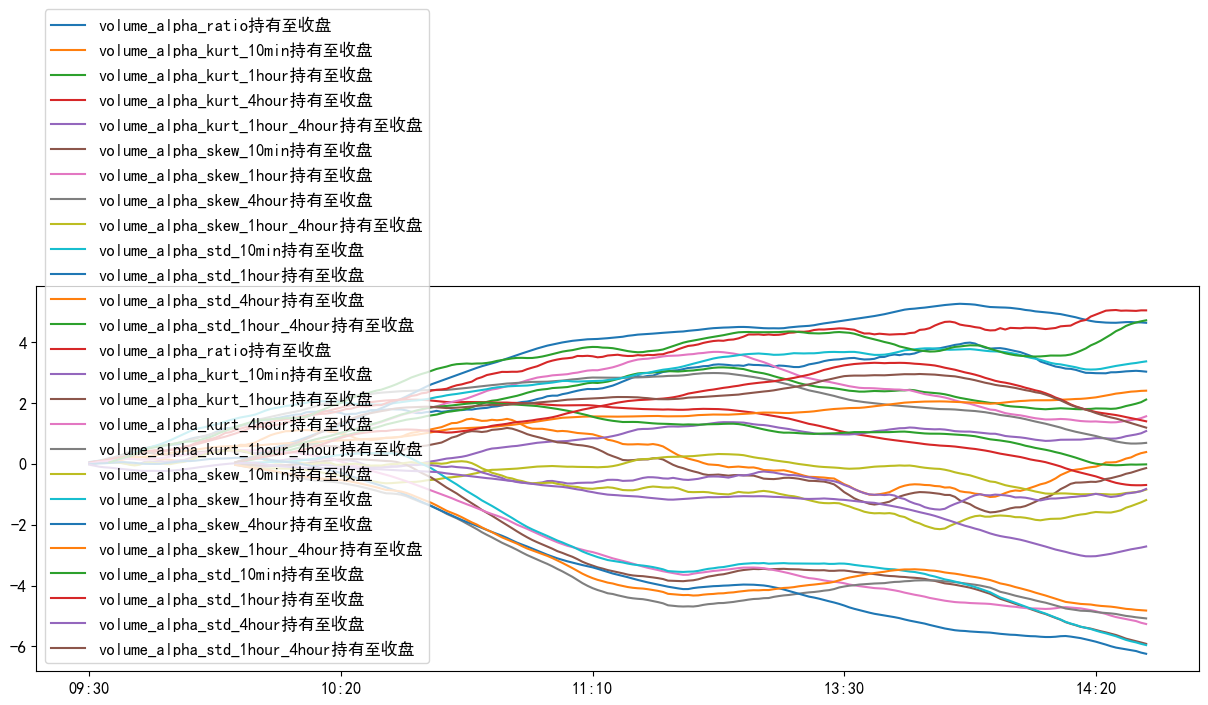

In [3]:
factor_list = ['volume_alpha_ratio',
            'volume_alpha_kurt_10min','volume_alpha_kurt_1hour','volume_alpha_kurt_4hour','volume_alpha_kurt_1hour_4hour',
            'volume_alpha_skew_10min','volume_alpha_skew_1hour','volume_alpha_skew_4hour','volume_alpha_skew_1hour_4hour',
            'volume_alpha_std_10min','volume_alpha_std_1hour','volume_alpha_std_4hour','volume_alpha_std_1hour_4hour']
def volume_ratio_2_factor(minquote):
    minquote.loc[:,'volume_min_mean'] = minquote['volume'].groupby(minquote.index.strftime('%H:%M')).apply(lambda x: x.rolling(5,min_periods=1).mean()).values
    minquote.loc[:,'volume_alpha_ratio'] = minquote['volume']/minquote['volume_min_mean']
    minquote.loc[:,'volume_alpha_kurt_10min'] = minquote['volume_alpha_ratio'].groupby(minquote.index.date).transform(lambda x:x.rolling(10,min_periods=5).kurt())
    minquote.loc[:,'volume_alpha_kurt_1hour'] = minquote['volume_alpha_ratio'].groupby(minquote.index.date).transform(lambda x:x.rolling(60,min_periods=30).kurt())
    minquote.loc[:,'volume_alpha_kurt_4hour'] = minquote['volume_alpha_ratio'].rolling(240,min_periods=120).kurt()
    minquote.loc[:,'volume_alpha_skew_10min'] = minquote['volume_alpha_ratio'].groupby(minquote.index.date).transform(lambda x:x.rolling(10,min_periods=5).skew())
    minquote.loc[:,'volume_alpha_skew_1hour'] = minquote['volume_alpha_ratio'].groupby(minquote.index.date).transform(lambda x:x.rolling(60,min_periods=30).skew())
    minquote.loc[:,'volume_alpha_skew_4hour'] = minquote['volume_alpha_ratio'].rolling(240,min_periods=120).skew()
    minquote.loc[:,'volume_alpha_std_10min'] = minquote['volume_alpha_ratio'].groupby(minquote.index.date).transform(lambda x:x.rolling(10,min_periods=5).std())
    minquote.loc[:,'volume_alpha_std_1hour'] = minquote['volume_alpha_ratio'].groupby(minquote.index.date).transform(lambda x:x.rolling(60,min_periods=30).std())
    minquote.loc[:,'volume_alpha_std_4hour'] = minquote['volume_alpha_ratio'].rolling(240,min_periods=120).std()
    
    minquote.loc[:,'volume_alpha_kurt_1hour_4hour'] = minquote['volume_alpha_kurt_1hour']/minquote['volume_alpha_kurt_4hour']
    minquote.loc[:,'volume_alpha_skew_1hour_4hour'] = minquote['volume_alpha_skew_1hour']/minquote['volume_alpha_skew_4hour']
    minquote.loc[:,'volume_alpha_std_1hour_4hour'] = minquote['volume_alpha_std_1hour']/minquote['volume_alpha_std_4hour']
    return minquote

FactorIC_ = FactorIC()
FactorIC_.CalcFactors(volume_ratio_2_factor)
result1 = FactorIC_.GetICResult(Fund_code='F159915',factor_list=factor_list)
result2 = FactorIC_.GetICResult(Fund_code='F588080',factor_list=factor_list)

F159915: volume: 持有至收盘 IC: 0.032, IR: 0.821
F159915: volume_kurt_10min: 持有至收盘 IC: -0.004, IR: -0.092
F159915: volume_kurt_1hour: 持有至收盘 IC: 0.007, IR: 0.278
F159915: volume_kurt_4hour: 持有至收盘 IC: -0.044, IR: -1.228
F159915: volume_kurt_1hour_4hour: 持有至收盘 IC: 0.021, IR: 0.593
F159915: volume_skew_10min: 持有至收盘 IC: -0.004, IR: -0.111
F159915: volume_skew_1hour: 持有至收盘 IC: 0.010, IR: 0.337
F159915: volume_skew_4hour: 持有至收盘 IC: -0.032, IR: -0.936
F159915: volume_skew_1hour_4hour: 持有至收盘 IC: 0.024, IR: 0.580
F159915: volume_std_10min: 持有至收盘 IC: 0.023, IR: 0.629
F159915: volume_std_1hour: 持有至收盘 IC: 0.049, IR: 1.273
F159915: volume_std_4hour: 持有至收盘 IC: 0.044, IR: 1.561
F159915: volume_std_1hour_4hour: 持有至收盘 IC: 0.030, IR: 0.800
F588080: volume: 持有至收盘 IC: 0.032, IR: 0.946
F588080: volume_kurt_10min: 持有至收盘 IC: 0.000, IR: 0.009
F588080: volume_kurt_1hour: 持有至收盘 IC: -0.026, IR: -0.941
F588080: volume_kurt_4hour: 持有至收盘 IC: 0.014, IR: 0.749
F588080: volume_kurt_1hour_4hour: 持有至收盘 IC: -0.021, IR: -0.545


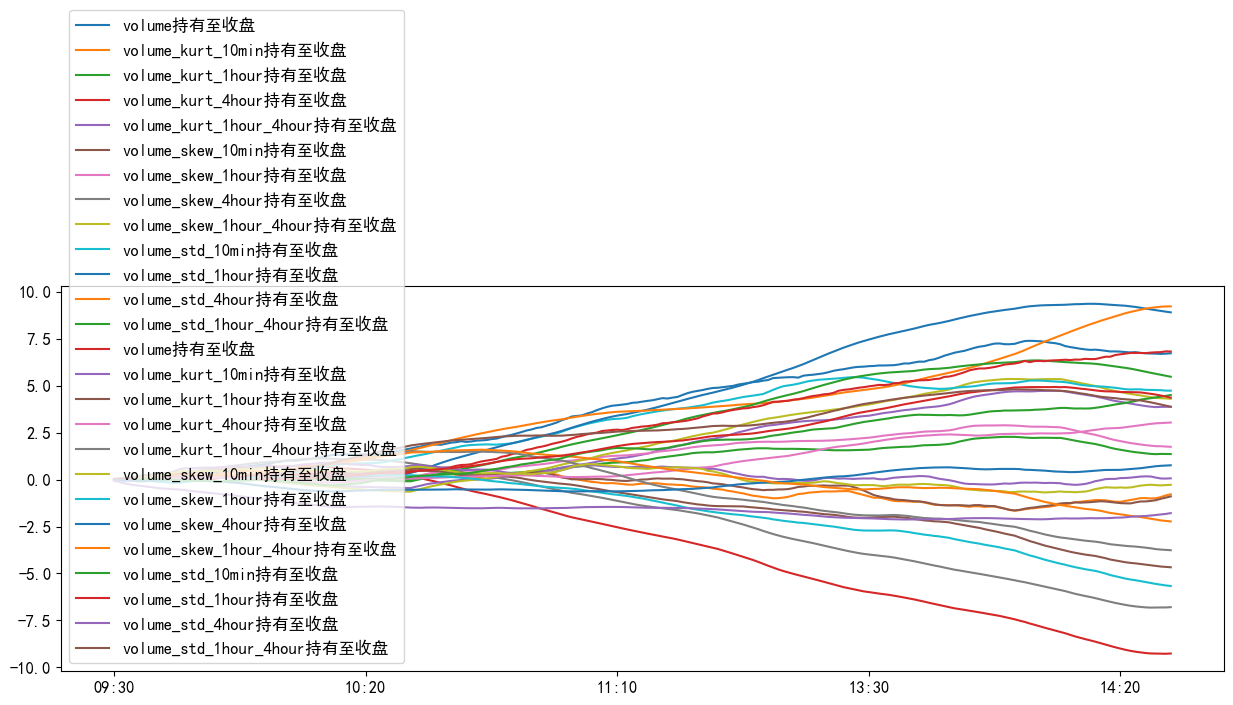

In [ ]:
factor_list = ['volume',
            'volume_kurt_10min','volume_kurt_1hour','volume_kurt_4hour','volume_kurt_1hour_4hour',
            'volume_skew_10min','volume_skew_1hour','volume_skew_4hour','volume_skew_1hour_4hour',
            'volume_std_10min','volume_std_1hour','volume_std_4hour','volume_std_1hour_4hour']
def volume_ratio_3_factor(minquote):
    minquote.loc[:,'volume_kurt_10min'] = minquote['volume'].groupby(minquote.index.date).transform(lambda x:x.rolling(10,min_periods=5).kurt())
    minquote.loc[:,'volume_kurt_1hour'] = minquote['volume'].groupby(minquote.index.date).transform(lambda x:x.rolling(60,min_periods=30).kurt())
    minquote.loc[:,'volume_kurt_4hour'] = minquote['volume'].rolling(240,min_periods=120).kurt()
    minquote.loc[:,'volume_skew_10min'] = minquote['volume'].groupby(minquote.index.date).transform(lambda x:x.rolling(10,min_periods=5).skew())
    minquote.loc[:,'volume_skew_1hour'] = minquote['volume'].groupby(minquote.index.date).transform(lambda x:x.rolling(60,min_periods=30).skew())
    minquote.loc[:,'volume_skew_4hour'] = minquote['volume'].rolling(240,min_periods=120).skew()
    minquote.loc[:,'volume_std_10min'] = minquote['volume'].groupby(minquote.index.date).transform(lambda x:x.rolling(10,min_periods=5).std())
    minquote.loc[:,'volume_std_1hour'] = minquote['volume'].groupby(minquote.index.date).transform(lambda x:x.rolling(60,min_periods=30).std())
    minquote.loc[:,'volume_std_4hour'] = minquote['volume'].rolling(240,min_periods=120).std()
    
    minquote.loc[:,'volume_kurt_1hour_4hour'] = minquote['volume_kurt_1hour']/minquote['volume_kurt_4hour']
    minquote.loc[:,'volume_skew_1hour_4hour'] = minquote['volume_skew_1hour']/minquote['volume_skew_4hour']
    minquote.loc[:,'volume_std_1hour_4hour'] = minquote['volume_std_1hour']/minquote['volume_std_4hour']
    return minquote

FactorIC_ = FactorIC()
FactorIC_.CalcFactors(volume_ratio_1_factor)
result1 = FactorIC_.GetICResult(Fund_code='F159915',factor_list=factor_list)
result2 = FactorIC_.GetICResult(Fund_code='F588080',factor_list=factor_list)

F159915: volume_up_10min: 持有至收盘 IC: 0.043, IR: 1.075
F159915: volume_down_10min: 持有至收盘 IC: 0.007, IR: 0.165
F159915: volume_up_1hour: 持有至收盘 IC: 0.049, IR: 2.026
F159915: volume_down_1hour: 持有至收盘 IC: 0.018, IR: 0.603
F159915: volume_up_4hour: 持有至收盘 IC: 0.018, IR: 0.428
F159915: volume_down_4hour: 持有至收盘 IC: 0.011, IR: 0.375
F159915: volume_up_down_ratio_10min: 持有至收盘 IC: 0.028, IR: 0.646
F159915: volume_up_down_ratio_1hour: 持有至收盘 IC: 0.042, IR: 1.046
F159915: volume_up_down_ratio_4hour: 持有至收盘 IC: 0.033, IR: 0.914
F588080: volume_up_10min: 持有至收盘 IC: 0.042, IR: 1.303
F588080: volume_down_10min: 持有至收盘 IC: 0.005, IR: 0.130
F588080: volume_up_1hour: 持有至收盘 IC: 0.065, IR: 3.143
F588080: volume_down_1hour: 持有至收盘 IC: 0.001, IR: 0.064
F588080: volume_up_4hour: 持有至收盘 IC: 0.036, IR: 0.693
F588080: volume_down_4hour: 持有至收盘 IC: -0.025, IR: -1.068
F588080: volume_up_down_ratio_10min: 持有至收盘 IC: 0.029, IR: 0.822
F588080: volume_up_down_ratio_1hour: 持有至收盘 IC: 0.062, IR: 3.614
F588080: volume_up_down_ratio_

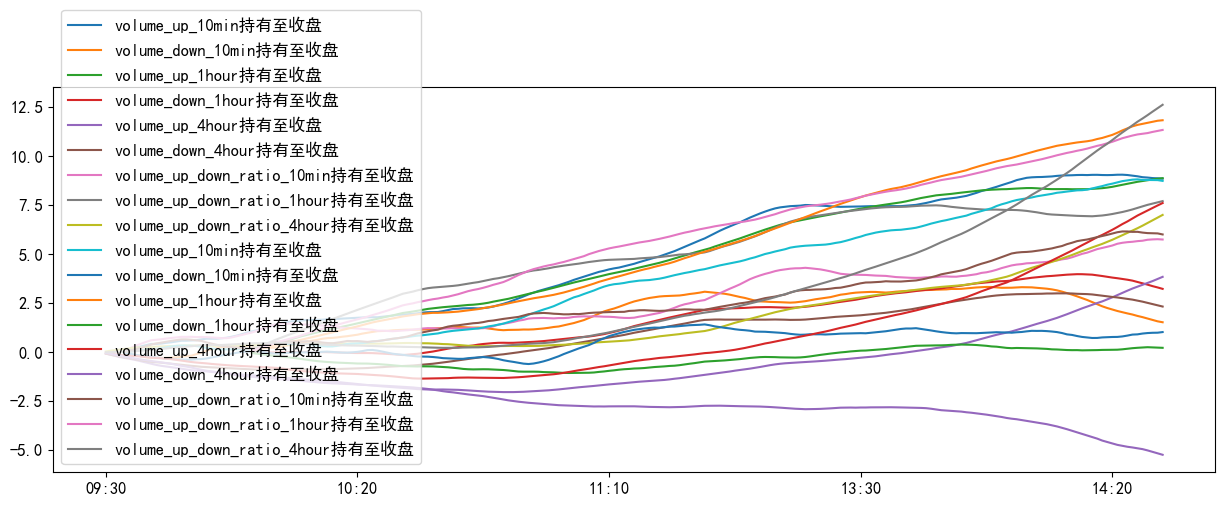

In [21]:
factor_list = ['volume_up_10min','volume_down_10min',
               'volume_up_1hour','volume_down_1hour',
               'volume_up_4hour','volume_down_4hour',
               'volume_up_down_ratio_10min','volume_up_down_ratio_1hour',
               'volume_up_down_ratio_4hour']

def volume_up_down_ratio(minquote):
    minquote.loc[:,'ret_min'] = minquote['close']/minquote['open']-1
    minquote.loc[:,'up_volume'] = minquote['volume']*(minquote['ret_min']>0)
    minquote.loc[:,'down_volume'] = minquote['volume']*(minquote['ret_min']<0)
    minquote.loc[:,'volume_up_10min'] = minquote['up_volume'].groupby(minquote.index.date).transform(lambda x:x.rolling(10,min_periods=5).sum())
    minquote.loc[:,'volume_down_10min'] = minquote['down_volume'].groupby(minquote.index.date).transform(lambda x:x.rolling(10,min_periods=5).sum())
    minquote.loc[:,'volume_up_1hour'] = minquote['up_volume'].groupby(minquote.index.date).transform(lambda x:x.rolling(60,min_periods=30).sum())
    minquote.loc[:,'volume_down_1hour'] = minquote['down_volume'].groupby(minquote.index.date).transform(lambda x:x.rolling(60,min_periods=30).sum())
    minquote.loc[:,'volume_up_4hour'] = minquote['up_volume'].rolling(240,min_periods=120).sum()
    minquote.loc[:,'volume_down_4hour'] = minquote['down_volume'].rolling(240,min_periods=120).sum()
    minquote.loc[:,'volume_up_down_ratio_10min'] = minquote['volume_up_10min']/minquote['volume_down_10min']
    minquote.loc[:,'volume_up_down_ratio_1hour'] = minquote['volume_up_1hour']/minquote['volume_down_1hour']
    minquote.loc[:,'volume_up_down_ratio_4hour'] = minquote['volume_up_4hour']/minquote['volume_down_4hour']
    return minquote

FactorIC_ = FactorIC()
FactorIC_.CalcFactors(volume_up_down_ratio)
result1 = FactorIC_.GetICResult(Fund_code='F159915',factor_list=factor_list)
result2 = FactorIC_.GetICResult(Fund_code='F588080',factor_list=factor_list)

<Axes: >

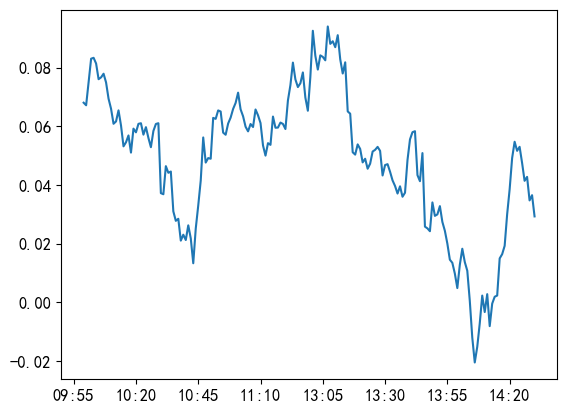

In [14]:
FactorIC_.ICresult['F159915']['volume_up_1hour'].plot()

平均持仓时间: 79.143448 分钟
胜率：0.506250
年化收益率：0.374906
年化夏普比率：2.712020


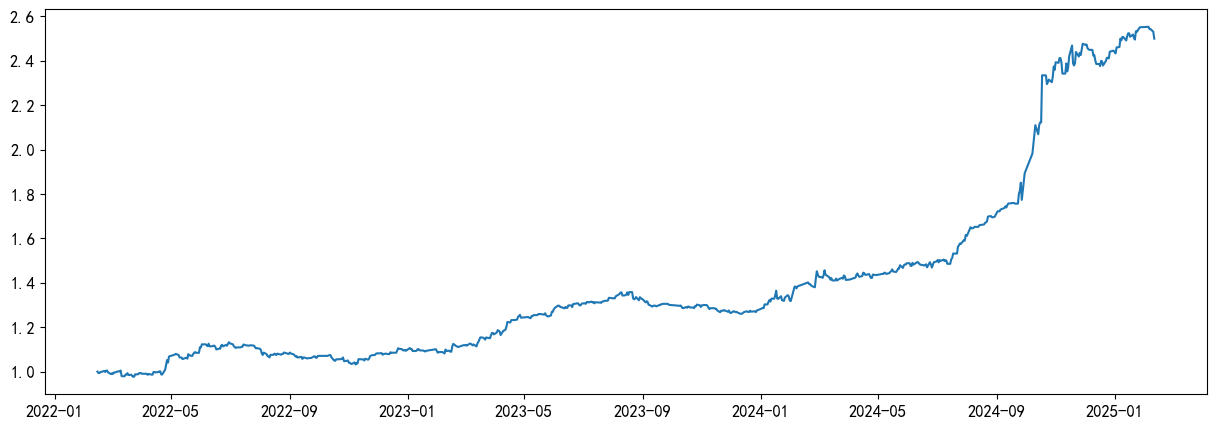

In [22]:
strategy = ETFIntradayStrategy(
    data=FactorIC_.minquotes['F588080'],
    factor_name = 'volume_up_1hour',
    direction = 1,
    periods = [('10:59','13:59')],
    rolling_is_rank = True,
    rolling_window = 480,
    bound_is_series = False,
    upper_bound = 0.8,
    lower_bound = 0.2,
    upper_stop_bound = 0.5,
    lower_stop_bound = 0.5,
    stop_loss_ratio = 0.02
)
daily_performance = strategy.get_performance()

#### 3.1.2 上下行波动占比

In [16]:
factor_list = ['downstd_ratio_10min','downstd_ratio_1hour','downstd_ratio_4hour']
def downstd_ratio_factor(minquote):
    minquote.loc[:,'ret_min'] = minquote['close']/minquote['open']-1
    minquote.loc[:,'downstd_ratio_10min'] = (minquote['ret_min']<0) *(minquote['ret_min']**2).rolling(10,min_periods=5).sum()/(minquote['ret_min']**2).rolling(10,min_periods=5).sum()
    minquote.loc[:,'downstd_ratio_1hour'] = (minquote['ret_min']<0) *(minquote['ret_min']**2).rolling(60,min_periods=30).sum()/(minquote['ret_min']**2).rolling(60,min_periods=30).sum()
    minquote.loc[:,'downstd_ratio_4hour'] = (minquote['ret_min']<0) *(minquote['ret_min']**2).rolling(240,min_periods=120).sum()/(minquote['ret_min']**2).rolling(240,min_periods=120).sum()
    return minquote

downstd_ratio_10min: 持有至收盘 IC: -0.007, IR: -0.192
downstd_ratio_1hour: 持有至收盘 IC: -0.007, IR: -0.191
downstd_ratio_4hour: 持有至收盘 IC: -0.007, IR: -0.191
downstd_ratio_10min: 持有至收盘 IC: -0.007, IR: -0.162
downstd_ratio_1hour: 持有至收盘 IC: -0.007, IR: -0.154
downstd_ratio_4hour: 持有至收盘 IC: -0.006, IR: -0.151


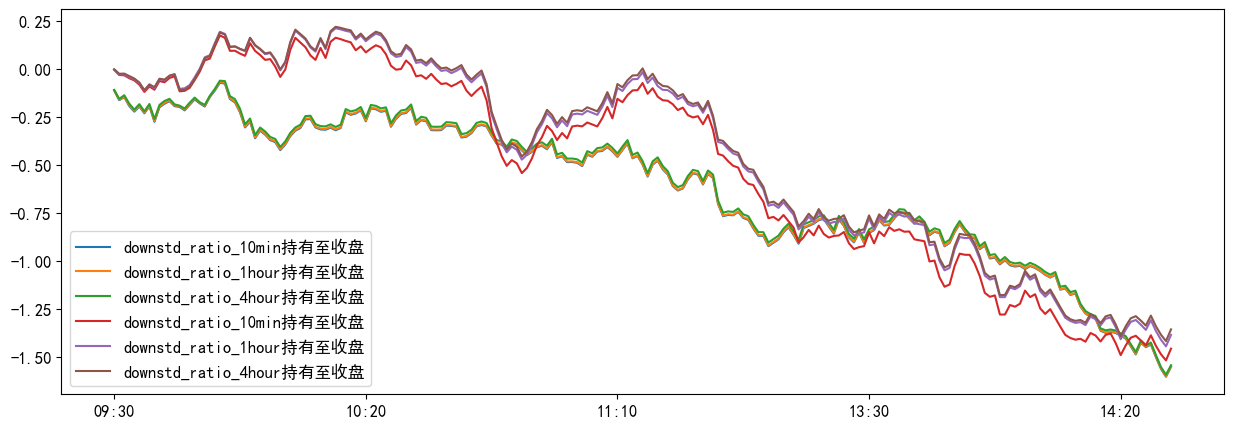

In [17]:
FactorIC_ = FactorIC()
FactorIC_.CalcFactors(downstd_ratio_factor)
result1 = FactorIC_.GetICResult(Fund_code='F159915',factor_list=factor_list)
result2 = FactorIC_.GetICResult(Fund_code='F588080',factor_list=factor_list)

平均持仓时间: 207.314483 分钟
胜率：0.468966
年化收益率：0.043603
年化夏普比率：0.195140


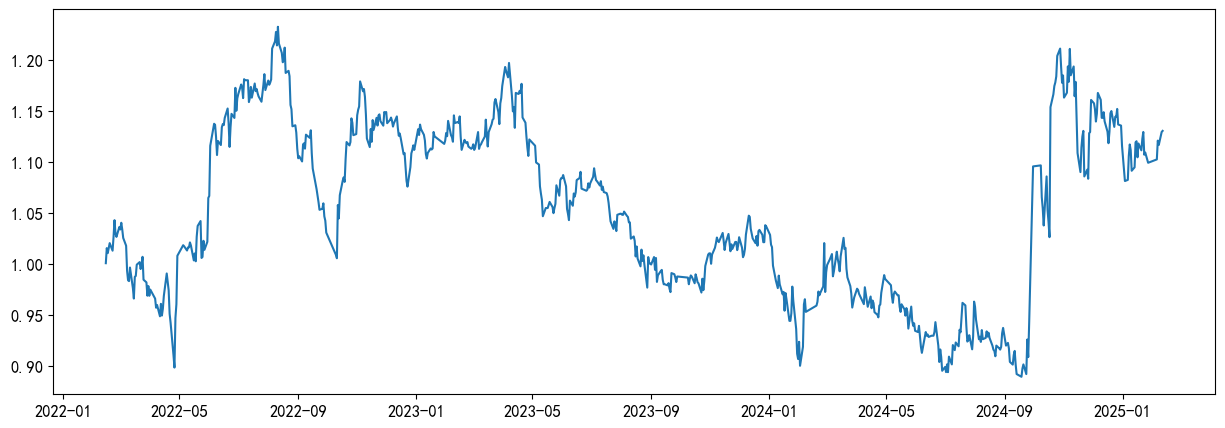

In [ ]:
strategy = ETFIntradayStrategy(
    data=FactorIC_.minquotes['F588080'],
    factor_name = 'downstd_ratio_10min',
    direction = 1,
    periods = [('09:59','10:59'),('13:29','14:29')],
    rolling_is_rank = True,
    rolling_window = 480,
    bound_is_series = False,
    upper_bound = 0.8,
    lower_bound = 0.2,
    upper_stop_bound = 0.5,
    lower_stop_bound = 0.5,
    stop_loss_ratio = 0.02
)
daily_performance = strategy.get_performance()

#### 3.1.3 amihud 非流动性

In [7]:
factor_list = ['amihud_10min','amihud_1hour','amihud_4hour']
def amihud_factor(minquote):
    minquote.loc[:,'ret_min_abs'] = (minquote['close']/minquote['open']-1).abs()
    minquote.loc[:,'amihud_10min'] = (minquote.loc[:,'ret_min_abs']/minquote.loc[:,'amount']).rolling(10,min_periods=5).sum()
    minquote.loc[:,'amihud_1hour'] = (minquote.loc[:,'ret_min_abs']/minquote.loc[:,'amount']).rolling(60,min_periods=30).sum()
    minquote.loc[:,'amihud_4hour'] = (minquote.loc[:,'ret_min_abs']/minquote.loc[:,'amount']).rolling(240,min_periods=120).sum()
    return minquote

F159915: amihud_10min: 持有至收盘 IC: -0.030, IR: -0.731
F159915: amihud_1hour: 持有至收盘 IC: -0.031, IR: -1.194
F159915: amihud_4hour: 持有至收盘 IC: 0.001, IR: 0.023
F588080: amihud_10min: 持有至收盘 IC: -0.039, IR: -1.211
F588080: amihud_1hour: 持有至收盘 IC: -0.027, IR: -0.871
F588080: amihud_4hour: 持有至收盘 IC: -0.011, IR: -0.273


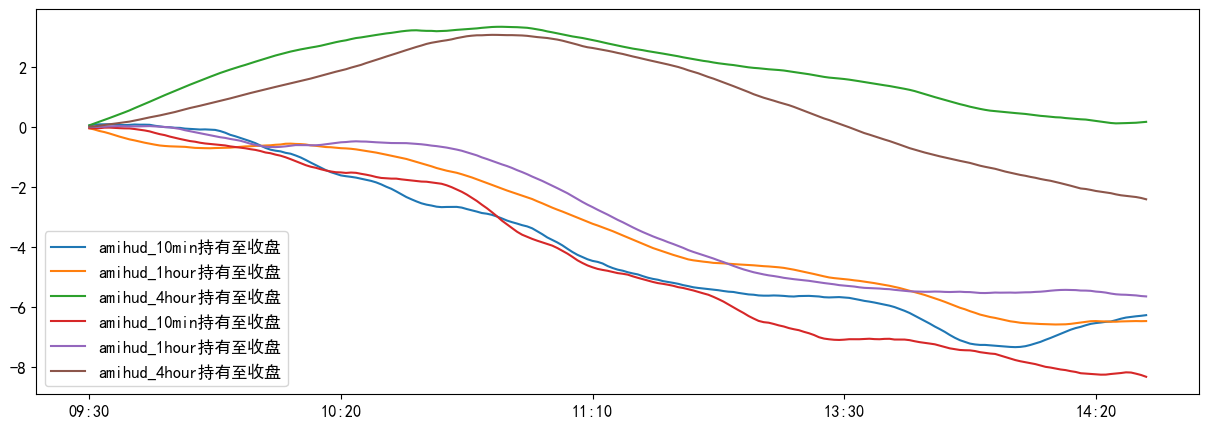

In [8]:
FactorIC_ = FactorIC()
FactorIC_.CalcFactors(amihud_factor)
result1 = FactorIC_.GetICResult(Fund_code='F159915',factor_list=factor_list)
result2 = FactorIC_.GetICResult(Fund_code='F588080',factor_list=factor_list)

平均持仓时间: 36.707586 分钟
胜率：0.422652
年化收益率：-0.112999
年化夏普比率：-1.242149


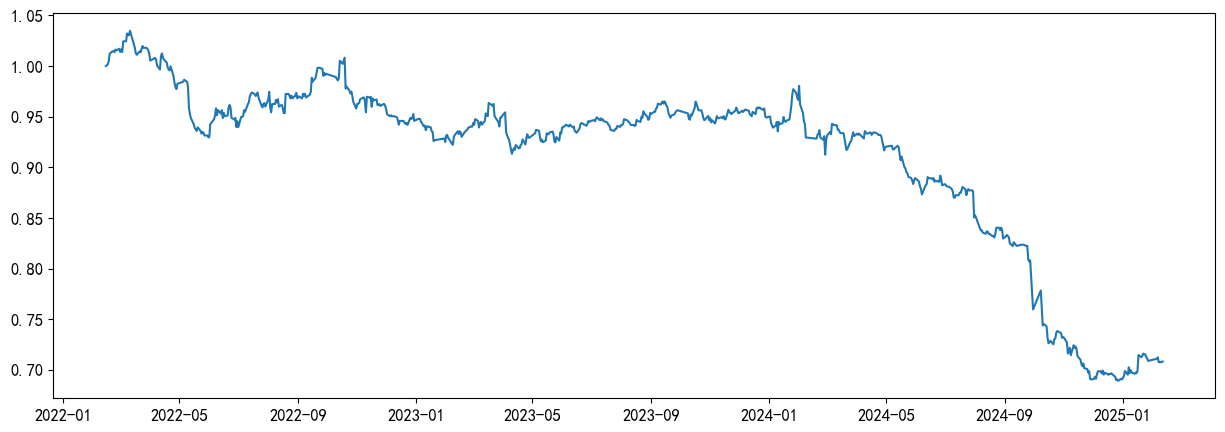

In [9]:
strategy = ETFIntradayStrategy(
    data=FactorIC_.minquotes['F588080'],
    factor_name = 'amihud_10min',
    direction = 1,
    periods = [('09:59','10:59'),('13:29','14:29')],
    rolling_is_rank = True,
    rolling_window = 480,
    bound_is_series = False,
    upper_bound = 0.8,
    lower_bound = 0.2,
    upper_stop_bound = 0.5,
    lower_stop_bound = 0.5,
    stop_loss_ratio = 0.02
)
daily_performance = strategy.get_performance()

#### 3.1.4 成交量自相关系数

In [20]:
factor_list = ['amihud_10min','amihud_1hour','amihud_4hour']
def volume_autocorr_factor(minquote):
    minquote.loc[:,'ret_min_abs'] = minquote.groupby(minquote.index.date).apply(lambda x:(x['close']/x['open']-1)).abs().values
    minquote.loc[:,'amihud_10min'] = (minquote.loc[:,'ret_min_abs']/minquote.loc[:,'amount']).rolling(10,min_periods=5).sum()
    minquote.loc[:,'amihud_1hour'] = (minquote.loc[:,'ret_min_abs']/minquote.loc[:,'amount']).rolling(60,min_periods=30).sum()
    minquote.loc[:,'amihud_4hour'] = (minquote.loc[:,'ret_min_abs']/minquote.loc[:,'amount']).rolling(240,min_periods=120).sum()
    return minquote

#### 3.1.5 振幅因子

In [21]:
factor_list = ['HML_10min','HML_1hour','HML_4hour','HML_10min_1hour']
def HML_factor(minquote):
    minquote.loc[:,'HML'] = minquote['high']/minquote['low']-1
    minquote.loc[:,'HML_10min'] = minquote['HML'].rolling(10,min_periods=5).sum()
    minquote.loc[:,'HML_1hour'] = minquote['HML'].rolling(60,min_periods=30).sum()
    minquote.loc[:,'HML_4hour'] = minquote['HML'].rolling(240,min_periods=120).sum()

    minquote.loc[:,'HML_10min_1hour'] = minquote['HML_10min']/minquote['HML_1hour']
    return minquote

HML_10min: 持有至收盘 IC: 0.022, IR: 0.598
HML_1hour: 持有至收盘 IC: 0.033, IR: 0.919
HML_4hour: 持有至收盘 IC: 0.006, IR: 0.234
HML_10min_1hour: 持有至收盘 IC: 0.011, IR: 0.295
HML_10min: 持有至收盘 IC: 0.005, IR: 0.125
HML_1hour: 持有至收盘 IC: 0.012, IR: 0.268
HML_4hour: 持有至收盘 IC: -0.018, IR: -0.547
HML_10min_1hour: 持有至收盘 IC: 0.011, IR: 0.308


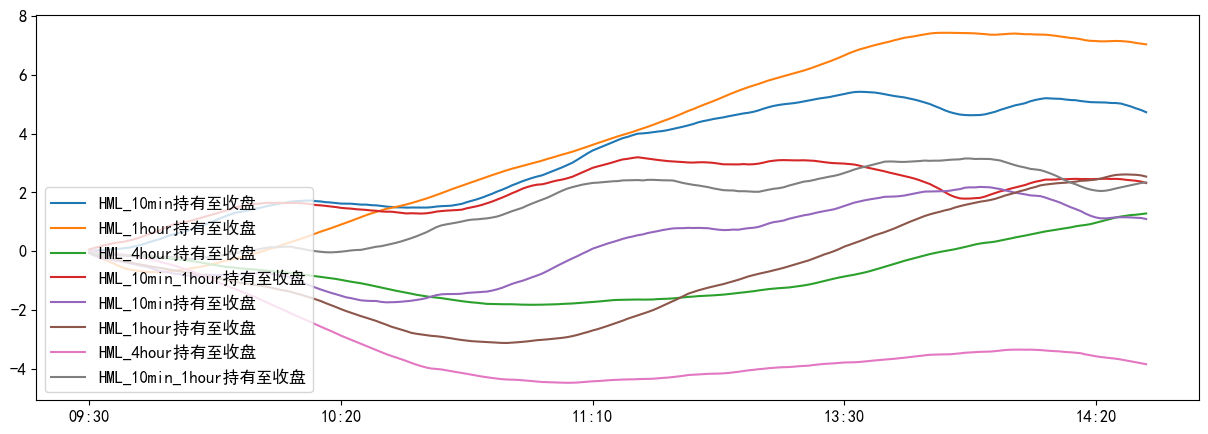

In [22]:
FactorIC_ = FactorIC()
FactorIC_.CalcFactors(HML_factor)
result1 = FactorIC_.GetICResult(Fund_code='F159915',factor_list=factor_list)
result2 = FactorIC_.GetICResult(Fund_code='F588080',factor_list=factor_list)

平均持仓时间: 46.201379 分钟
胜率：0.500690
年化收益率：-0.083055
年化夏普比率：-0.671858


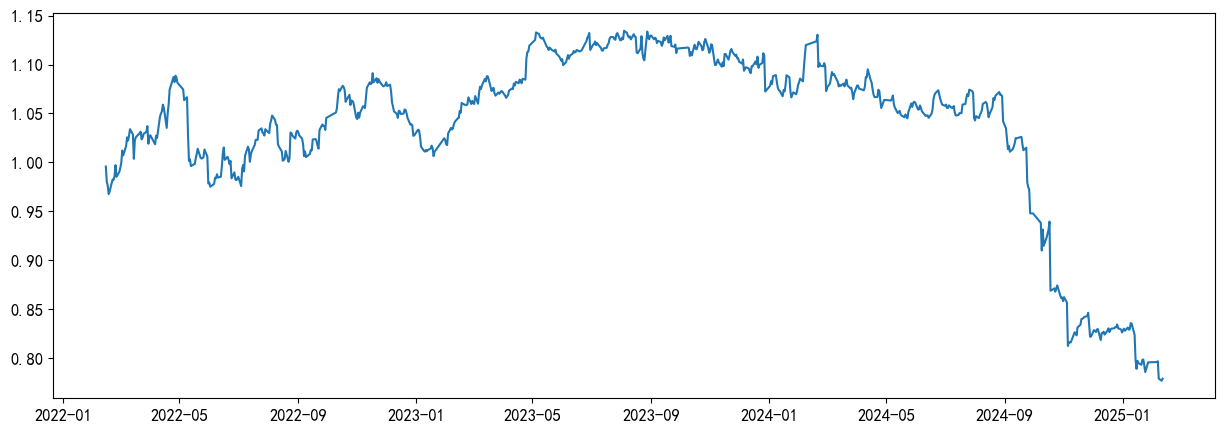

In [ ]:
## 未引入止损条件 F588080  F159915
Fund_code = 'F159915'
factor_name = 'HML_10min'
window = 240
strategy1 = ETFIntradayStrategy(
    data = FactorIC_.minquotes[Fund_code],
    factor_name = factor_name,
    LimitOpenTime = '10:30', # 限制10:30以后再开仓
    direction = -1,
    window = window,
    BuyBound = 0.7,
    SellBound = 0.1
)
performance = strategy1.get_performance()

#### 3.1.6 上下影线占比

#### 3.1.7 量价相关性因子

F159915: price_volume_corr_10min: 持有至收盘 IC: 0.024, IR: 0.525
F159915: price_volume_corr_1hour: 持有至收盘 IC: 0.030, IR: 0.749
F159915: price_volume_corr_4hour: 持有至收盘 IC: -0.017, IR: -0.354
F159915: price_volume1_corr_10min: 持有至收盘 IC: 0.023, IR: 0.543
F159915: price_volume1_corr_1hour: 持有至收盘 IC: 0.037, IR: 0.881
F159915: price_volume1_corr_4hour: 持有至收盘 IC: -0.017, IR: -0.349
F159915: ret_volume_corr_10min: 持有至收盘 IC: 0.016, IR: 0.333
F159915: ret_volume_corr_1hour: 持有至收盘 IC: 0.025, IR: 0.357
F159915: ret_volume_corr_4hour: 持有至收盘 IC: 0.049, IR: 1.688
F159915: ret_volume1_corr_10min: 持有至收盘 IC: -0.003, IR: -0.100
F159915: ret_volume1_corr_1hour: 持有至收盘 IC: 0.013, IR: 0.549
F159915: ret_volume1_corr_4hour: 持有至收盘 IC: -0.006, IR: -0.178
F159915: price_volume_corr_10min_1hour: 持有至收盘 IC: -0.008, IR: -0.184
F159915: ret_volume_corr_10min_1hour: 持有至收盘 IC: 0.010, IR: 0.274
F588080: price_volume_corr_10min: 持有至收盘 IC: 0.027, IR: 0.615
F588080: price_volume_corr_1hour: 持有至收盘 IC: 0.028, IR: 0.875
F588080: p

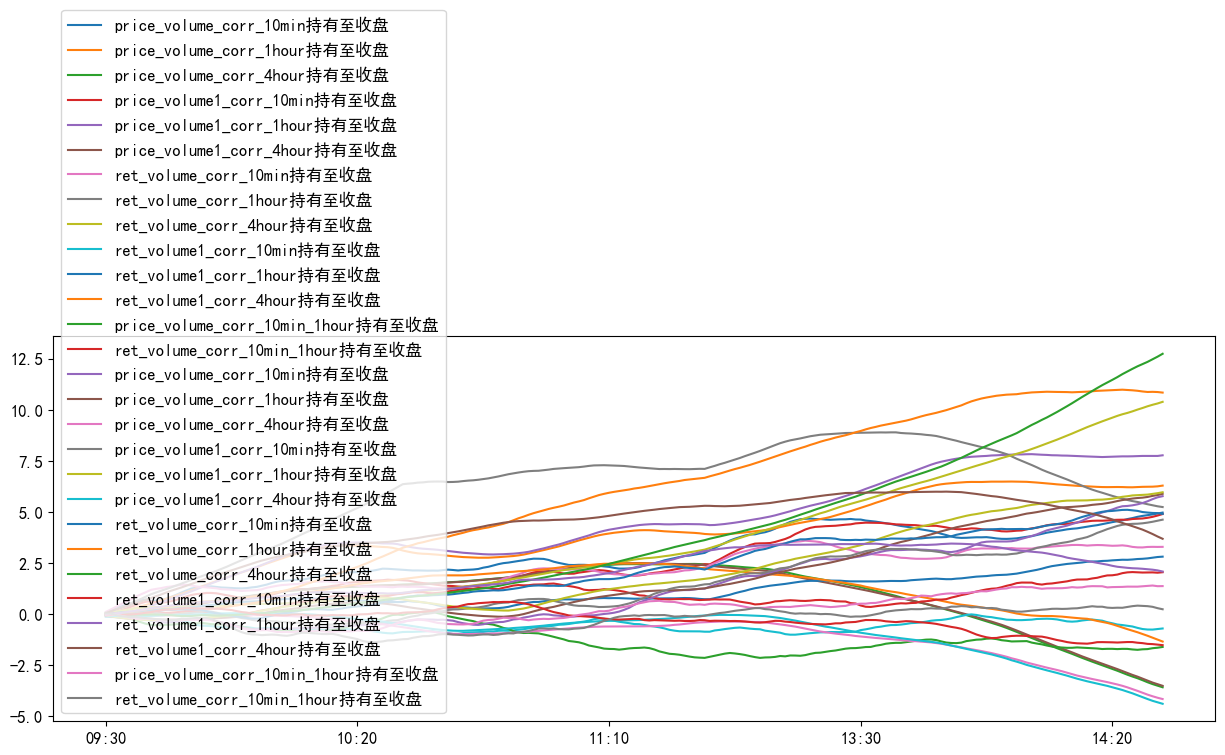

In [31]:
factor_list = ['price_volume_corr_10min','price_volume_corr_1hour','price_volume_corr_4hour',
               'price_volume1_corr_10min','price_volume1_corr_1hour','price_volume1_corr_4hour',
               'ret_volume_corr_10min','ret_volume_corr_1hour','ret_volume_corr_4hour',
               'ret_volume1_corr_10min','ret_volume1_corr_1hour','ret_volume1_corr_4hour',
               'price_volume_corr_10min_1hour','ret_volume_corr_10min_1hour',]
def price_volume_corr_factor(minquote):
    minquote.loc[:,'volume_ratio'] = minquote['volume']/minquote['volume'].rolling(480,min_periods=60).mean()
    minquote.loc[:,'ret_min'] = minquote['close']/minquote['open']-1
    minquote.loc[:,'price_volume_corr_10min'] = minquote['close'].rolling(10,min_periods=5).corr(minquote['volume_ratio'])
    minquote.loc[:,'price_volume_corr_1hour'] = minquote['close'].rolling(60,min_periods=30).corr(minquote['volume_ratio'])
    minquote.loc[:,'price_volume_corr_4hour'] = minquote['close'].rolling(240,min_periods=120).corr(minquote['volume_ratio'])
    minquote.loc[:,'price_volume1_corr_10min'] = minquote['close'].rolling(10,min_periods=5).corr(minquote['volume_ratio'].shift())
    minquote.loc[:,'price_volume1_corr_1hour'] = minquote['close'].rolling(60,min_periods=30).corr(minquote['volume_ratio'].shift())
    minquote.loc[:,'price_volume1_corr_4hour'] = minquote['close'].rolling(240,min_periods=120).corr(minquote['volume_ratio'].shift())
    
    minquote.loc[:,'ret_volume_corr_10min'] = minquote['ret_min'].rolling(10,min_periods=5).corr(minquote['volume_ratio'])
    minquote.loc[:,'ret_volume_corr_1hour'] = minquote['ret_min'].rolling(60,min_periods=30).corr(minquote['volume_ratio'])
    minquote.loc[:,'ret_volume_corr_4hour'] = minquote['ret_min'].rolling(240,min_periods=120).corr(minquote['volume_ratio'])
    minquote.loc[:,'ret_volume1_corr_10min'] = minquote['ret_min'].rolling(10,min_periods=5).corr(minquote['volume_ratio'].shift())
    minquote.loc[:,'ret_volume1_corr_1hour'] = minquote['ret_min'].rolling(60,min_periods=30).corr(minquote['volume_ratio'].shift())
    minquote.loc[:,'ret_volume1_corr_4hour'] = minquote['ret_min'].rolling(240,min_periods=120).corr(minquote['volume_ratio'].shift())

    minquote.loc[:,'price_volume_corr_10min_1hour'] = minquote['price_volume_corr_10min']/minquote['price_volume_corr_1hour']
    minquote.loc[:,'ret_volume_corr_10min_1hour'] = minquote['ret_volume_corr_10min']/minquote['ret_volume_corr_1hour']
    return minquote

FactorIC_ = FactorIC()
FactorIC_.CalcFactors(price_volume_corr_factor)
result1 = FactorIC_.GetICResult(Fund_code='F159915',factor_list=factor_list)
result2 = FactorIC_.GetICResult(Fund_code='F588080',factor_list=factor_list)

平均持仓时间: 112.333793 分钟
胜率：0.519369
年化收益率：0.444527
年化夏普比率：2.859394


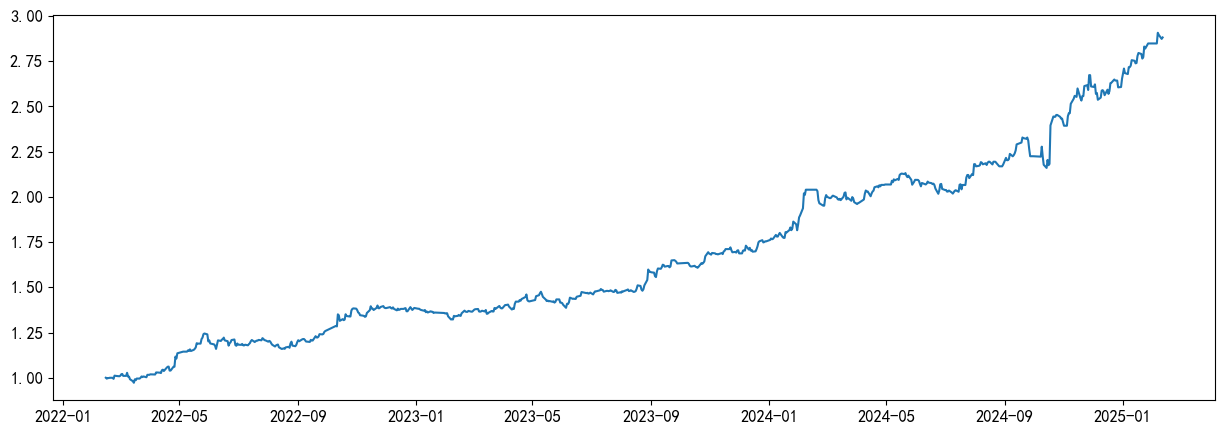

In [32]:
strategy = ETFIntradayStrategy(
    data=FactorIC_.minquotes['F588080'],
    factor_name = 'ret_volume_corr_4hour',
    direction = 1,
    periods = [('09:59','14:50')],
    rolling_is_rank = True,
    rolling_window = 480,
    bound_is_series = False,
    upper_bound = 0.8,
    lower_bound = 0.2,
    upper_stop_bound = 0.6,
    lower_stop_bound = 0.4,
    stop_loss_ratio = 0.02
)
daily_performance = strategy.get_performance()

#### 3.1.8 RSI指标

F159915: RSI_10min: 持有至收盘 IC: 0.027, IR: 0.683
F159915: RSI_1hour: 持有至收盘 IC: 0.040, IR: 0.889
F159915: RSI_4hour: 持有至收盘 IC: 0.024, IR: 0.365
F588080: RSI_10min: 持有至收盘 IC: 0.033, IR: 0.882
F588080: RSI_1hour: 持有至收盘 IC: 0.058, IR: 1.691
F588080: RSI_4hour: 持有至收盘 IC: 0.050, IR: 0.580


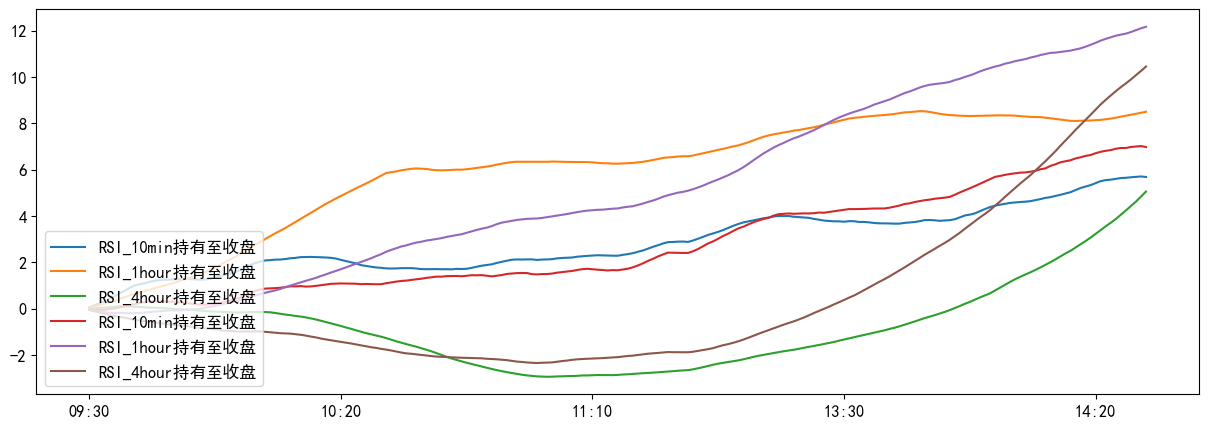

In [28]:
factor_list = ['RSI_10min','RSI_1hour','RSI_4hour']
def RSI_factor(minquote):
    minquote.loc[:,'close_diff'] = minquote['close'] - minquote['close'].shift(1)
    minquote.loc[:,'RSI_10min'] = -(minquote['close_diff']*(minquote['close_diff'] > 0)).rolling(10,min_periods=5).mean() / (minquote['close_diff']*(minquote['close_diff'] < 0)).rolling(10,min_periods=5).mean()
    minquote.loc[:,'RSI_1hour'] = -(minquote['close_diff']*(minquote['close_diff'] > 0)).rolling(60,min_periods=30).mean() / (minquote['close_diff']*(minquote['close_diff'] < 0)).rolling(60,min_periods=30).mean()
    minquote.loc[:,'RSI_4hour'] = -(minquote['close_diff']*(minquote['close_diff'] > 0)).rolling(240,min_periods=120).mean() / (minquote['close_diff']*(minquote['close_diff'] < 0)).rolling(240,min_periods=120).mean()
    return minquote

FactorIC_ = FactorIC()
FactorIC_.CalcFactors(RSI_factor)
result1 = FactorIC_.GetICResult(Fund_code='F159915',factor_list=factor_list)
result2 = FactorIC_.GetICResult(Fund_code='F588080',factor_list=factor_list)

平均持仓时间: 59.995862 分钟
胜率：0.452080
年化收益率：0.175037
年化夏普比率：1.497110


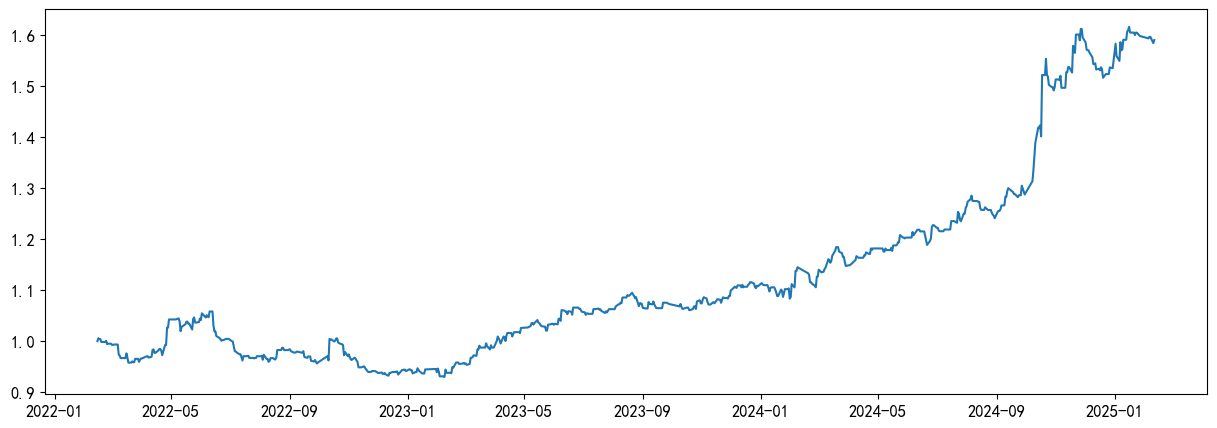

In [30]:
strategy = ETFIntradayStrategy(
    data=FactorIC_.minquotes['F588080'],
    factor_name = 'RSI_4hour',
    direction = 1,
    periods = [('12:59','14:30')],
    rolling_is_rank = True,
    rolling_window = 480,
    bound_is_series = False,
    upper_bound = 0.9,
    lower_bound = 0.1,
    upper_stop_bound = 0.6,
    lower_stop_bound = 0.4,
    stop_loss_ratio = 0.02
)
daily_performance = strategy.get_performance()

#### 3.1.9 MACD指标

In [15]:
factor_list = ['MACD_10min_30min','MACD_30min_1hour','MACD_1hour_4hour']
def MACD_factor(minquote):
    minquote.loc[:,'EMA_10min'] = minquote['close'].ewm(span=10,min_periods=5).mean()
    minquote.loc[:,'EMA_30min'] = minquote['close'].ewm(span=30,min_periods=15).mean()
    minquote.loc[:,'EMA_1hour'] = minquote['close'].ewm(span=60,min_periods=30).mean()
    minquote.loc[:,'EMA_4hour'] = minquote['close'].ewm(span=240,min_periods=120).mean()

    minquote.loc[:,'MACD_10min_30min'] = minquote['EMA_10min'] - minquote['EMA_30min']
    minquote.loc[:,'MACD_30min_1hour'] = minquote['EMA_30min'] - minquote['EMA_1hour']
    minquote.loc[:,'MACD_1hour_4hour'] = minquote['EMA_1hour'] - minquote['EMA_4hour']
    return minquote

F159915: MACD_10min_30min: 持有至收盘 IC: 0.040, IR: 0.920
F159915: MACD_30min_1hour: 持有至收盘 IC: 0.042, IR: 1.037
F159915: MACD_1hour_4hour: 持有至收盘 IC: 0.053, IR: 1.731
F588080: MACD_10min_30min: 持有至收盘 IC: 0.055, IR: 1.795
F588080: MACD_30min_1hour: 持有至收盘 IC: 0.062, IR: 1.892
F588080: MACD_1hour_4hour: 持有至收盘 IC: 0.076, IR: 1.203


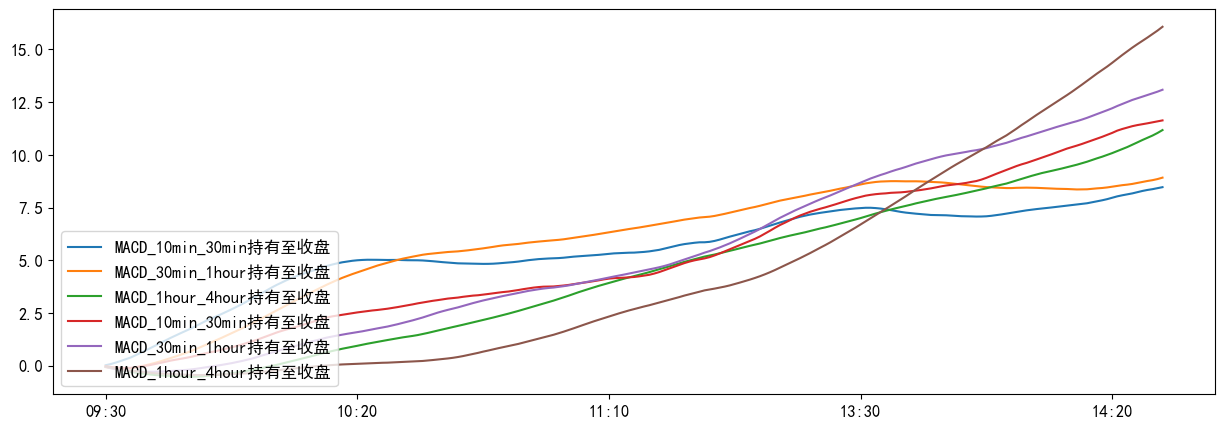

In [16]:
FactorIC_ = FactorIC()
FactorIC_.CalcFactors(MACD_factor)
result1 = FactorIC_.GetICResult(Fund_code='F159915',factor_list=factor_list)
result2 = FactorIC_.GetICResult(Fund_code='F588080',factor_list=factor_list)

平均持仓时间: 113.513103 分钟
胜率：0.494234
年化收益率：0.478690
年化夏普比率：2.858506


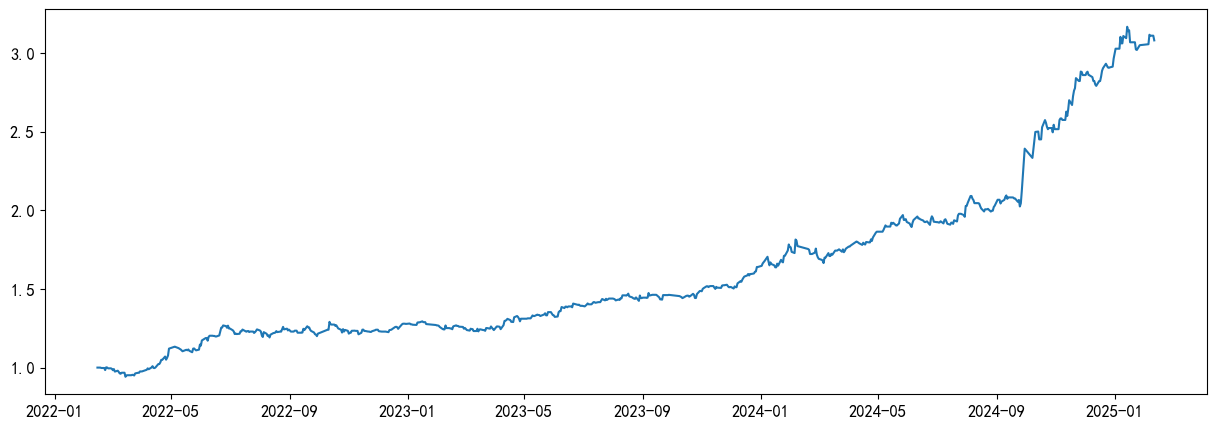

In [ ]:
strategy = ETFIntradayStrategy(
    data=FactorIC_.minquotes['F588080'],
    factor_name = 'MACD_1hour_4hour',
    direction = 1,
    periods = [('09:59','10:59'),('13:29','14:29')],
    rolling_is_rank = True,
    rolling_window = 960,
    bound_is_series = False,
    upper_bound = 0.8,
    lower_bound = 0.2,
    upper_stop_bound = 0.6,
    lower_stop_bound = 0.4,
    stop_loss_ratio = 0.02
)
daily_performance = strategy.get_performance()

#### 3.1.10 boll 指标

In [19]:
factor_list = ['BOLLup_10min','BOLLup_30min','BOLLup_1hour','BOLLup_4hour',
               'close_BOLLup_10min','close_BOLLup_30min','close_BOLLup_1hour','close_BOLLup_4hour']
def BOLL_factor(minquote):
    minquote.loc[:,'BOLLup_10min'] = minquote['close'].rolling(10,min_periods=5).mean()+2*minquote['close'].rolling(10,min_periods=5).std()
    minquote.loc[:,'BOLLup_30min'] = minquote['close'].rolling(30,min_periods=15).mean()+2*minquote['close'].rolling(30,min_periods=15).std()
    minquote.loc[:,'BOLLup_1hour'] = minquote['close'].rolling(60,min_periods=30).mean()+2*minquote['close'].rolling(60,min_periods=30).std()
    minquote.loc[:,'BOLLup_4hour'] = minquote['close'].rolling(240,min_periods=120).mean()+2*minquote['close'].rolling(240,min_periods=120).std()
    minquote.loc[:,'close_BOLLup_10min'] = minquote['close']/minquote.loc[:,'BOLLup_10min']
    minquote.loc[:,'close_BOLLup_30min'] = minquote['close']/minquote.loc[:,'BOLLup_30min']
    minquote.loc[:,'close_BOLLup_1hour'] = minquote['close']/minquote.loc[:,'BOLLup_1hour']
    minquote.loc[:,'close_BOLLup_4hour'] = minquote['close']/minquote.loc[:,'BOLLup_4hour']
    return minquote

F159915: BOLLup_10min: 持有至收盘 IC: 0.069, IR: 1.475
F159915: BOLLup_30min: 持有至收盘 IC: 0.060, IR: 1.197
F159915: BOLLup_1hour: 持有至收盘 IC: 0.051, IR: 0.939
F159915: BOLLup_4hour: 持有至收盘 IC: 0.055, IR: 1.685
F159915: close_BOLLup_10min: 持有至收盘 IC: 0.009, IR: 0.231
F159915: close_BOLLup_30min: 持有至收盘 IC: 0.023, IR: 0.594
F159915: close_BOLLup_1hour: 持有至收盘 IC: 0.025, IR: 0.574
F159915: close_BOLLup_4hour: 持有至收盘 IC: 0.032, IR: 1.503
F588080: BOLLup_10min: 持有至收盘 IC: 0.067, IR: 0.890
F588080: BOLLup_30min: 持有至收盘 IC: 0.056, IR: 0.737
F588080: BOLLup_1hour: 持有至收盘 IC: 0.041, IR: 0.525
F588080: BOLLup_4hour: 持有至收盘 IC: -0.010, IR: -0.278
F588080: close_BOLLup_10min: 持有至收盘 IC: 0.018, IR: 0.500
F588080: close_BOLLup_30min: 持有至收盘 IC: 0.039, IR: 1.042
F588080: close_BOLLup_1hour: 持有至收盘 IC: 0.045, IR: 1.483
F588080: close_BOLLup_4hour: 持有至收盘 IC: 0.066, IR: 1.379


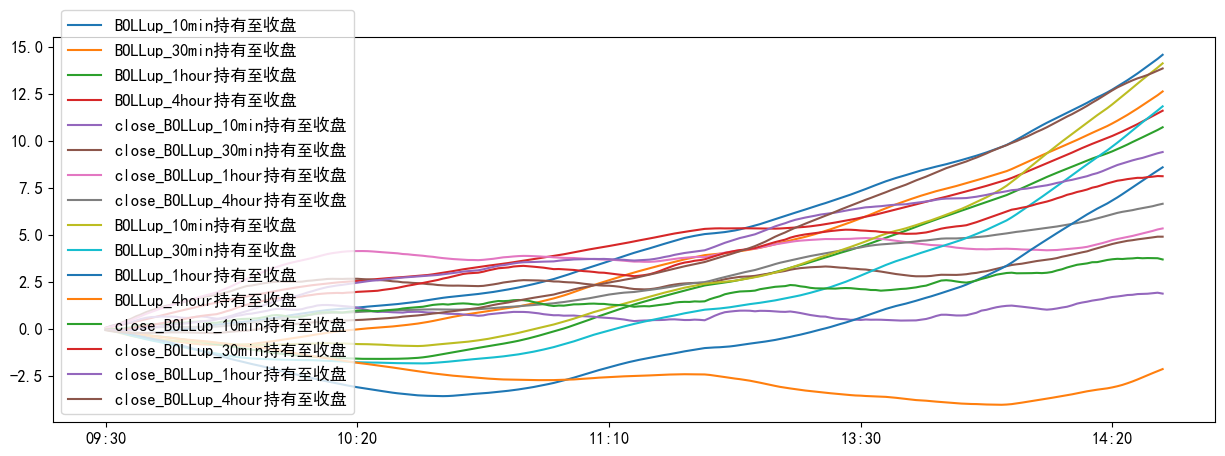

In [20]:
FactorIC_ = FactorIC()
FactorIC_.CalcFactors(BOLL_factor)
result1 = FactorIC_.GetICResult(Fund_code='F159915',factor_list=factor_list)
result2 = FactorIC_.GetICResult(Fund_code='F588080',factor_list=factor_list)

平均持仓时间: 89.924138 分钟
胜率：0.461980
年化收益率：0.497379
年化夏普比率：3.080081


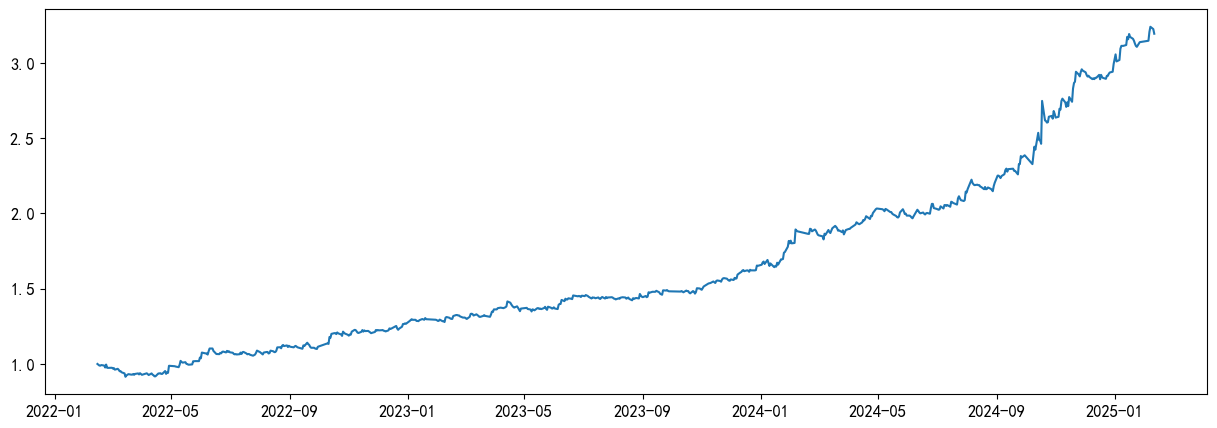

In [21]:
strategy = ETFIntradayStrategy(
    data=FactorIC_.minquotes['F588080'],
    factor_name = 'close_BOLLup_4hour',
    direction = 1,
    periods = [('09:59','10:59'),('13:29','14:29')],
    rolling_is_rank = True,
    rolling_window = 960,
    bound_is_series = False,
    upper_bound = 0.8,
    lower_bound = 0.2,
    upper_stop_bound = 0.6,
    lower_stop_bound = 0.4,
    stop_loss_ratio = 0.02
)
daily_performance = strategy.get_performance()

#### 3.1.11 西部的上下限突破因子

In [23]:
factor_list = ['upper_bound','lower_bound','close_upper_bound','close_lower_bound']

def GetMomBound_factor(minquote):
    """计算动量策略的上下限"""
    minquote.loc[:,'open0930'] = minquote.groupby(minquote.index.date)['open'].transform(lambda x: x.iloc[0])  # 0930开盘价
    minquote.loc[:,'move'] = (minquote['close']/minquote['open0930']-1).abs()  # 计算每分钟的价格位移
    minquote.loc[:,'move_rolling10'] = minquote.groupby(minquote.index.strftime('%H:%M'))['move'].transform(lambda x: x.rolling(10,min_periods=5).mean())
    minquote.loc[:,'close_last'] = (minquote.groupby(minquote.index.date)['close'].transform(lambda x: x.iloc[-1])).shift(240)  # 前一日收盘价
    minquote.loc[:,'upper_bound'] = minquote[['open0930','close_last']].max(axis=1)*(1+minquote['move_rolling10'])  # 计算上限
    minquote.loc[:,'lower_bound'] = minquote[['open0930','close_last']].min(axis=1)*(1-minquote['move_rolling10'])  # 计算下限
    minquote.loc[:,'close_upper_bound'] = minquote['close']/minquote['upper_bound']
    minquote.loc[:,'close_lower_bound'] = minquote['close']/minquote['lower_bound']
    return minquote

F159915: upper_bound: 持有至收盘 IC: 0.001, IR: 0.042
F159915: lower_bound: 持有至收盘 IC: -0.016, IR: -0.793
F159915: close_upper_bound: 持有至收盘 IC: 0.067, IR: 1.198
F159915: close_lower_bound: 持有至收盘 IC: 0.081, IR: 1.930
F588080: upper_bound: 持有至收盘 IC: -0.046, IR: -1.686
F588080: lower_bound: 持有至收盘 IC: -0.022, IR: -0.582
F588080: close_upper_bound: 持有至收盘 IC: 0.099, IR: 1.695
F588080: close_lower_bound: 持有至收盘 IC: 0.092, IR: 1.186


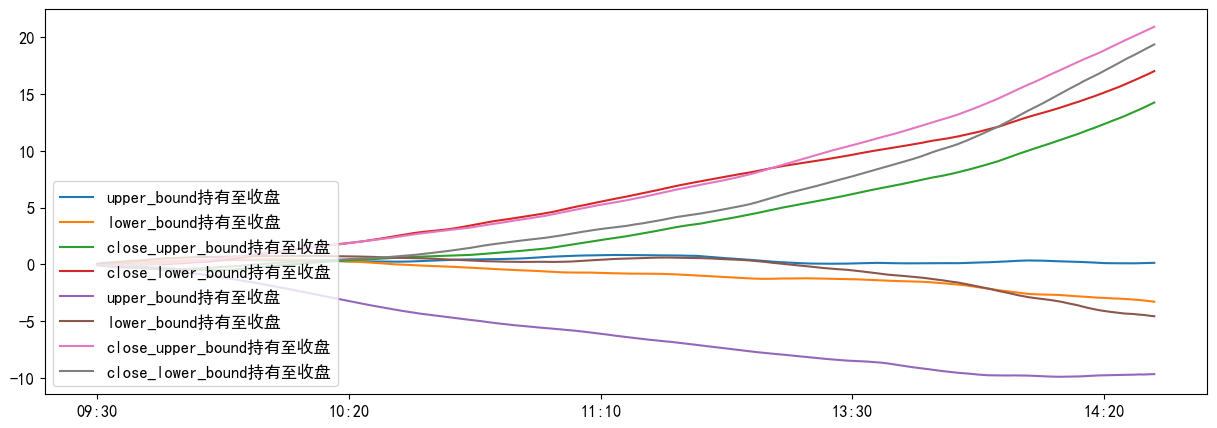

In [24]:
FactorIC_ = FactorIC()
FactorIC_.CalcFactors(GetMomBound_factor)
result1 = FactorIC_.GetICResult(Fund_code='F159915',factor_list=factor_list)
result2 = FactorIC_.GetICResult(Fund_code='F588080',factor_list=factor_list)

平均持仓时间: 120.702069 分钟
胜率：0.505022
年化收益率：0.670296
年化夏普比率：4.270343


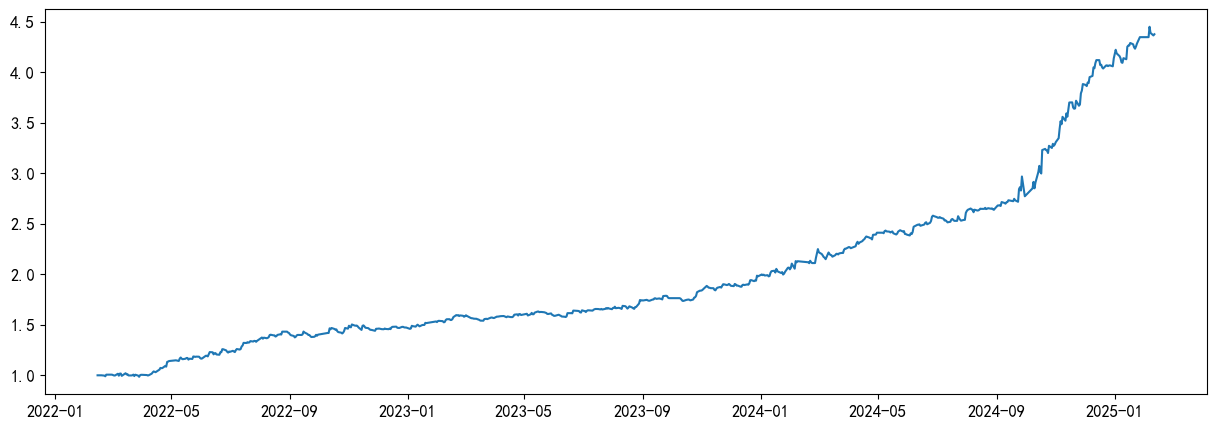

In [25]:
strategy = ETFIntradayStrategy(
    data=FactorIC_.minquotes['F159915'],
    factor_name = 'close_upper_bound',
    direction = 1,
    periods = [('10:00','14:50')],
    rolling_is_rank = True,
    rolling_window = 480,
    bound_is_series = False,
    upper_bound = 0.8,
    lower_bound = 0.2,
    upper_stop_bound = 0.5,
    lower_stop_bound = 0.5,
    stop_loss_ratio = 0.02
)
daily_performance = strategy.get_performance()

#### 3.1.12 能量潮 ADL

F159915: ADL_10min: 持有至收盘 IC: 0.027, IR: 0.572
F159915: ADL_1hour: 持有至收盘 IC: 0.037, IR: 0.635
F159915: ADL_4hour: 持有至收盘 IC: 0.043, IR: 0.808
F588080: ADL_10min: 持有至收盘 IC: 0.031, IR: 0.856
F588080: ADL_1hour: 持有至收盘 IC: 0.059, IR: 2.622
F588080: ADL_4hour: 持有至收盘 IC: 0.071, IR: 1.070


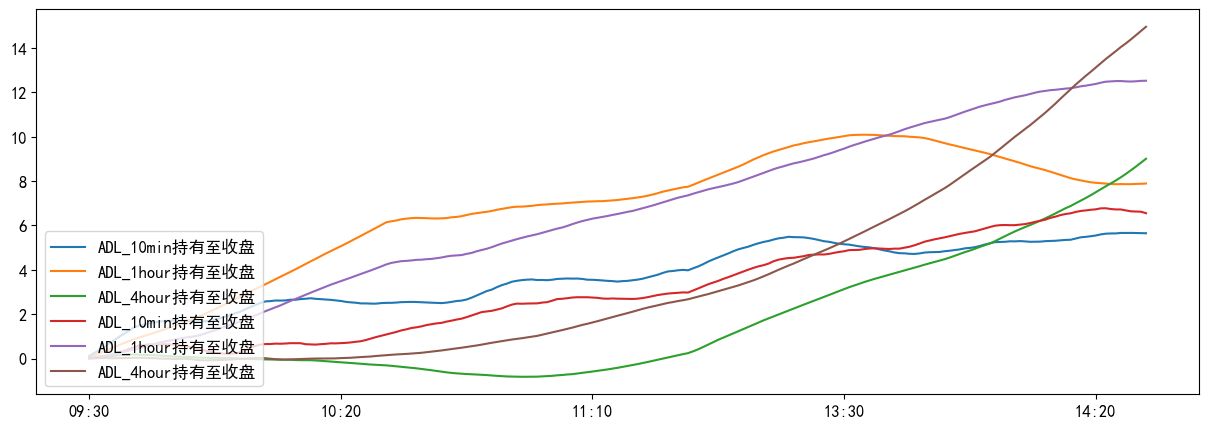

In [33]:
factor_list = ['ADL_10min','ADL_1hour','ADL_4hour']
def ADL_factor(minquote):
    minquote.loc[:,'ret_min'] = minquote['close']/minquote['open']-1
    minquote.loc[:,'volume_ratio'] = minquote['volume']/minquote['volume'].rolling(480,min_periods=60).mean()
    minquote.loc[:,'ADL'] = minquote['ret_min']*minquote['volume']
    minquote.loc[:,'ADL_10min'] = minquote['ADL'].rolling(10,min_periods=5).sum()
    minquote.loc[:,'ADL_1hour'] = minquote['ADL'].rolling(60,min_periods=30).sum()
    minquote.loc[:,'ADL_4hour'] = minquote['ADL'].rolling(240,min_periods=120).sum()
    return minquote
FactorIC_ = FactorIC()
FactorIC_.CalcFactors(ADL_factor)
result1 = FactorIC_.GetICResult(Fund_code='F159915',factor_list=factor_list)
result2 = FactorIC_.GetICResult(Fund_code='F588080',factor_list=factor_list)

<Axes: >

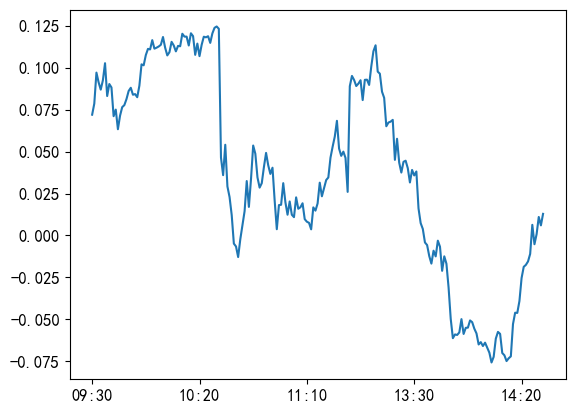

In [34]:
FactorIC_.ICresult['F159915']['ADL_1hour'].plot()

平均持仓时间: 78.092414 分钟
胜率：0.491597
年化收益率：0.544757
年化夏普比率：3.653910


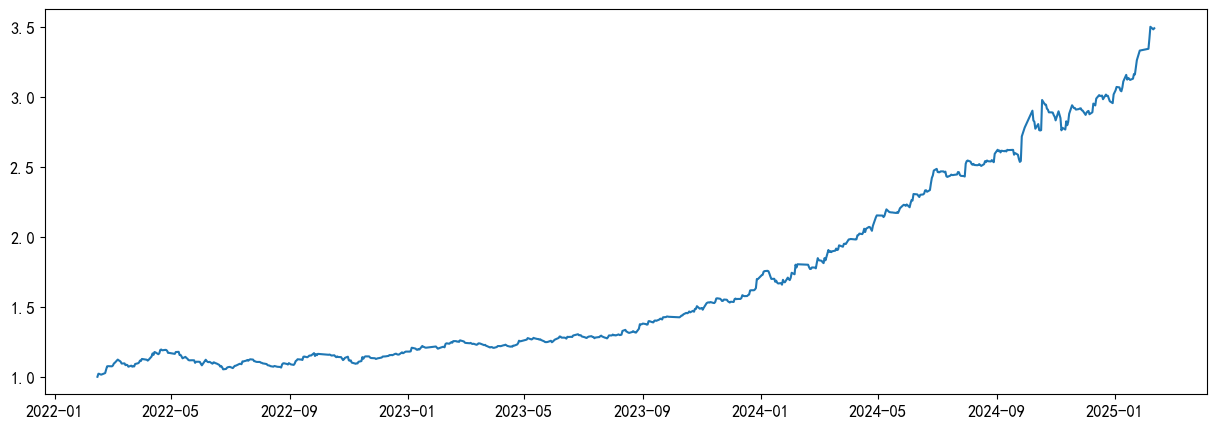

In [36]:
strategy = ETFIntradayStrategy(
    data=FactorIC_.minquotes['F159915'],
    factor_name = 'ADL_1hour',
    direction = 1,
    periods = [('09:29','12:50')],
    rolling_is_rank = True,
    rolling_window = 480,
    bound_is_series = False,
    upper_bound = 0.8,
    lower_bound = 0.2,
    upper_stop_bound = 0.5,
    lower_stop_bound = 0.5,
    stop_loss_ratio = 0.02
)
daily_performance = strategy.get_performance()

#### 总结

In [4]:
## 总结所有的因子及其相关性测试
final_factor_list = ['close_lower_bound','close_BOLLup_4hour','MACD_1hour_4hour','RSI_1hour','ret_volume_corr_4hour','volume_std_1hour','amihud_10min']
def CalcFinalFactors(minquote):
    minquote.loc[:,'open0930'] = minquote.groupby(minquote.index.date)['open'].transform(lambda x: x.iloc[0])  # 0930开盘价
    minquote.loc[:,'move'] = (minquote['close']/minquote['open0930']-1).abs()  # 计算每分钟的价格位移
    minquote.loc[:,'move_rolling10'] = minquote.groupby(minquote.index.strftime('%H:%M'))['move'].transform(lambda x: x.rolling(10,min_periods=5).mean())
    minquote.loc[:,'close_last'] = (minquote.groupby(minquote.index.date)['close'].transform(lambda x: x.iloc[-1])).shift(240)  # 前一日收盘价
    minquote.loc[:,'lower_bound'] = minquote[['open0930','close_last']].min(axis=1)*(1-minquote['move_rolling10'])  # 计算下限
    minquote.loc[:,'close_lower_bound'] = minquote['close']/minquote['lower_bound']
    
    minquote.loc[:,'BOLLup_4hour'] = minquote['close'].rolling(240,min_periods=120).mean()+2*minquote['close'].rolling(240,min_periods=120).std()
    minquote.loc[:,'close_BOLLup_4hour'] = minquote['close']/minquote.loc[:,'BOLLup_4hour']

    minquote.loc[:,'EMA_1hour'] = minquote['close'].ewm(span=60,min_periods=30).mean()
    minquote.loc[:,'EMA_4hour'] = minquote['close'].ewm(span=240,min_periods=120).mean()
    minquote.loc[:,'MACD_1hour_4hour'] = minquote['EMA_1hour'] - minquote['EMA_4hour']
    
    minquote.loc[:,'close_diff'] = minquote['close'] - minquote['close'].shift(1)
    minquote.loc[:,'RSI_1hour'] = -(minquote['close_diff']*(minquote['close_diff'] > 0)).rolling(60,min_periods=30).mean() / (minquote['close_diff']*(minquote['close_diff'] < 0)).rolling(60,min_periods=30).mean()
    
    minquote.loc[:,'volume_ratio'] = minquote['volume']/minquote['volume'].rolling(480,min_periods=60).mean()
    minquote.loc[:,'ret_min'] = minquote['close']/minquote['open']-1
    minquote.loc[:,'ret_volume_corr_4hour'] = minquote['ret_min'].rolling(240,min_periods=120).corr(minquote['volume_ratio'])
    
    minquote.loc[:,'volume_std_1hour'] = minquote['volume_ratio'].groupby(minquote.index.date).transform(lambda x:x.rolling(60,min_periods=30).std())
    
    minquote.loc[:,'ret_min_abs'] = (minquote['close']/minquote['open']-1).abs()
    minquote.loc[:,'amihud_10min'] = (minquote.loc[:,'ret_min_abs']/minquote.loc[:,'amount']).rolling(10,min_periods=5).sum()
    return minquote


In [9]:
FactorIC_ = FactorIC()
FactorIC_.CalcFactors(CalcFinalFactors)
factors = FactorIC_.minquotes

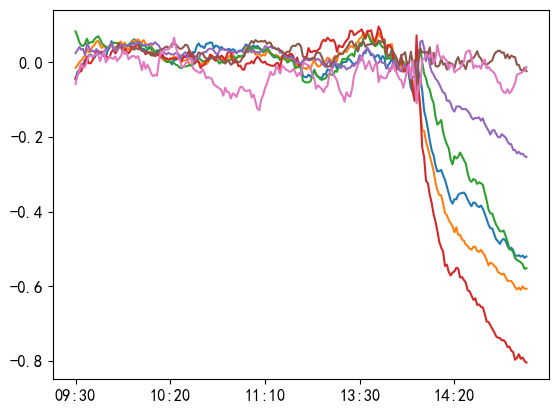

In [ ]:
factor = final_factor_list[0]
for factor in final_factor_list:
    factors['F588080'][factor] = factors['F588080'][factor].rolling(960,min_periods=15).rank(pct=True)
    IC = factors['F588080'].groupby(factors['F588080'].index.strftime("%H:%M")).apply(lambda x:x[f'{factor}'].corr(x['htc_ret']))
    #IC.plot()

In [11]:
factors['F588080'][factor]

2022-02-14 09:30:00         NaN
2022-02-14 09:31:00         NaN
2022-02-14 09:32:00         NaN
2022-02-14 09:33:00         NaN
2022-02-14 09:34:00         NaN
                         ...   
2025-02-11 14:55:00    1.002477
2025-02-11 14:56:00    1.002577
2025-02-11 14:57:00    1.002678
2025-02-11 14:58:00    1.001415
2025-02-11 14:59:00    1.002174
Name: close_lower_bound, Length: 174000, dtype: float64

In [15]:
factors['F588080'][final_factor_list]

close_lower_bound  close_BOLLup_4hour  MACD_1hour_4hour  \
2022-02-14 09:30:00                NaN                 NaN               NaN   
2022-02-14 09:31:00                NaN                 NaN               NaN   
2022-02-14 09:32:00                NaN                 NaN               NaN   
2022-02-14 09:33:00                NaN                 NaN               NaN   
2022-02-14 09:34:00                NaN                 NaN               NaN   
...                                ...                 ...               ...   
2025-02-11 14:55:00           1.002477            0.989407         -0.000694   
2025-02-11 14:56:00           1.002577            0.989537         -0.000744   
2025-02-11 14:57:00           1.002678            0.989692         -0.000792   
2025-02-11 14:58:00           1.001415            0.988906         -0.000862   
2025-02-11 14:59:00           1.002174            0.990010         -0.000904   

                     RSI_1hour  ret_volume_corr_4hour  volume_std_1hour  \
2022-02-14 09:30:00        NaN                    NaN               NaN   
2022-02-14 09:31:00        NaN                    NaN               NaN   
2022-02-14 09:32:00        NaN                    NaN               NaN   
2022-02-14 09:33:00        NaN                    NaN               NaN   
2022-02-14 09:34:00        NaN                    NaN               NaN   
...                        ...                    ...               ...   
2025-02-11 14:55:00   0.740741              -0.028351          1.357296   
2025-02-11 14:56:00   0.740741              -0.028387          1.356122   
2025-02-11 14:57:00   0.769231              -0.027960          1.353495   
2025-02-11 14:58:00   0.769231              -0.029874          1.352304   
2025-02-11 14:59:00   0.807692              -0.031077          1.352465   

                     amihud_10min  
2022-02-14 09:30:00           NaN  
2022-02-14 09:31:00           NaN  
2022-02-14 09:32:00           NaN  
2022-02-14 09:33:00           NaN  
2022-02-14 09:34:00  6.371305e-09  
...                           ...  
2025-02-11 14:55:00  2.658562e-09  
2025-02-11 14:56:00  2.574855e-09  
2025-02-11 14:57:00  2.515828e-09  
2025-02-11 14:58:00  2.511253e-09  
2025-02-11 14:59:00  2.846992e-09  

[174000 rows x 7 columns]

In [20]:
for factor in final_factor_list:
    factors['F588080'][factor] = factors['F588080'][factor].rolling(30,min_periods=15).rank(pct=True)

In [17]:
factors['F588080']

windcode   open   high    low  close     volume  \
2022-02-14 09:30:00  588080.SH  1.200  1.200  1.190  1.190  4578800.0   
2022-02-14 09:31:00  588080.SH  1.191  1.191  1.185  1.186  3978803.0   
2022-02-14 09:32:00  588080.SH  1.186  1.194  1.185  1.193  2997000.0   
2022-02-14 09:33:00  588080.SH  1.193  1.198  1.193  1.198  2019600.0   
2022-02-14 09:34:00  588080.SH  1.199  1.202  1.198  1.202  3673700.0   
...                        ...    ...    ...    ...    ...        ...   
2025-02-11 14:55:00  588080.SH  1.050  1.050  1.049  1.049  1961700.0   
2025-02-11 14:56:00  588080.SH  1.049  1.050  1.049  1.049  2055800.0   
2025-02-11 14:57:00  588080.SH  1.049  1.050  1.049  1.049  1814100.0   
2025-02-11 14:58:00  588080.SH  1.049  1.050  1.048  1.048  8599791.0   
2025-02-11 14:59:00  588080.SH  1.048  1.049  1.048  1.049  2710397.0   

                        amount  change  pctchange   htc_ret  ...  EMA_4hour  \
2022-02-14 09:30:00  5473856.0  -0.014  -0.011628  0.013434  ...        NaN   
2022-02-14 09:31:00  4719635.0  -0.004  -0.003361  0.017707  ...        NaN   
2022-02-14 09:32:00  3566074.0   0.007   0.005902  0.011735  ...        NaN   
2022-02-14 09:33:00  2412967.0   0.005   0.004191  0.006672  ...        NaN   
2022-02-14 09:34:00  4409735.0   0.004   0.003339  0.004160  ...        NaN   
...                        ...     ...        ...       ...  ...        ...   
2025-02-11 14:55:00  2059391.0  -0.001  -0.000952  0.000000  ...   1.051968   
2025-02-11 14:56:00  2157369.0   0.000   0.000000  0.000000  ...   1.051944   
2025-02-11 14:57:00  1904087.0   0.000   0.000000  0.000000  ...   1.051919   
2025-02-11 14:58:00  9019040.0  -0.001  -0.000953  0.000954  ...   1.051887   
2025-02-11 14:59:00  2842083.0   0.001   0.000954       NaN  ...   1.051863   

                     MACD_1hour_4hour  close_diff  RSI_1hour  volume_ratio  \
2022-02-14 09:30:00               NaN         NaN        NaN           NaN   
2022-02-14 09:31:00               NaN      -0.004        NaN           NaN   
2022-02-14 09:32:00               NaN       0.007        NaN           NaN   
2022-02-14 09:33:00               NaN       0.005        NaN           NaN   
2022-02-14 09:34:00               NaN       0.004        NaN           NaN   
...                               ...         ...        ...           ...   
2025-02-11 14:55:00         -0.000694      -0.001   0.740741      0.404388   
2025-02-11 14:56:00         -0.000744       0.000   0.740741      0.424601   
2025-02-11 14:57:00         -0.000792       0.000   0.769231      0.375195   
2025-02-11 14:58:00         -0.000862      -0.001   0.769231      1.775533   
2025-02-11 14:59:00         -0.000904       0.001   0.807692      0.560289   

                      ret_min  ret_volume_corr_4hour  volume_std_1hour  \
2022-02-14 09:30:00 -0.008333                    NaN               NaN   
2022-02-14 09:31:00 -0.004198                    NaN               NaN   
2022-02-14 09:32:00  0.005902                    NaN               NaN   
2022-02-14 09:33:00  0.004191                    NaN               NaN   
2022-02-14 09:34:00  0.002502                    NaN               NaN   
...                       ...                    ...               ...   
2025-02-11 14:55:00 -0.000952              -0.028351          1.357296   
2025-02-11 14:56:00  0.000000              -0.028387          1.356122   
2025-02-11 14:57:00  0.000000              -0.027960          1.353495   
2025-02-11 14:58:00 -0.000953              -0.029874          1.352304   
2025-02-11 14:59:00  0.000954              -0.031077          1.352465   

                     ret_min_abs  amihud_10min  
2022-02-14 09:30:00     0.008333           NaN  
2022-02-14 09:31:00     0.004198           NaN  
2022-02-14 09:32:00     0.005902           NaN  
2022-02-14 09:33:00     0.004191           NaN  
2022-02-14 09:34:00     0.002502  6.371305e-09  
...                          ...           ...  
2025-02-11 14:55:00     0.0

In [ ]:
factors['F588080']['htc_ret'].apply(lambda x: 1 if x > 0 else -1)

2022-02-14 09:30:00    0.013434
2022-02-14 09:31:00    0.017707
2022-02-14 09:32:00    0.011735
2022-02-14 09:33:00    0.006672
2022-02-14 09:34:00    0.004160
                         ...   
2025-02-11 14:55:00    0.000000
2025-02-11 14:56:00    0.000000
2025-02-11 14:57:00    0.000000
2025-02-11 14:58:00    0.000954
2025-02-11 14:59:00         NaN
Name: htc_ret, Length: 174000, dtype: float64

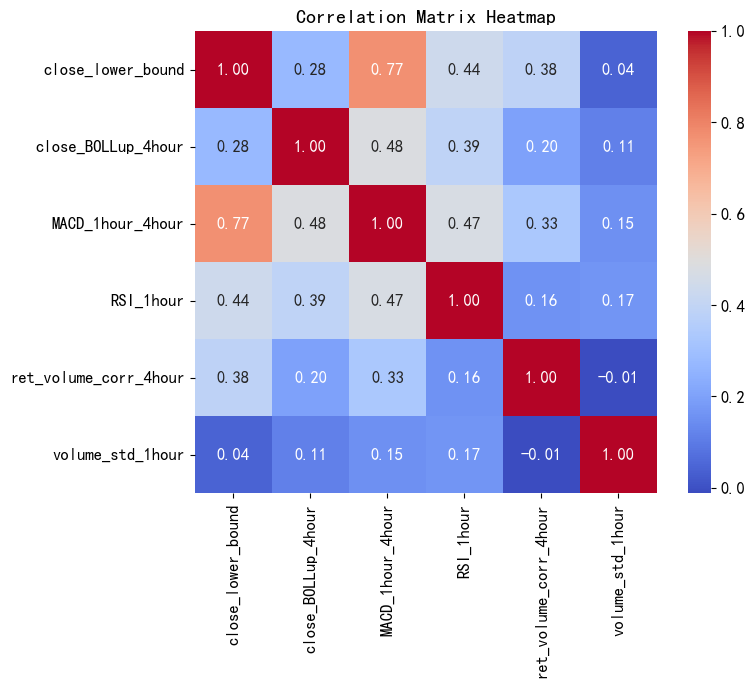

In [ ]:
corr_matrix = factors['F588080'][final_factor_list].corr()
# 创建热力图
plt.figure(figsize=(8, 6))  # 设置图形的大小
heatmap = sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', square=True)
plt.title('因子相关系数矩阵')
plt.show()

### 3.2 查看机器学习因子的表现

In [1]:
from main import *


In [16]:
localpath = '.'
with open(f'{localpath}/test1.yaml', 'r') as file:
    args = DictToObj(yaml.safe_load(file))
set_seed(args.SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ALSTM(input_size=len(args.FACTOR_LIST),
            embedding_dim = args.EMBEDDING_DIM, 
            hidden_size=args.HIDDEN_SIZE, 
            Q = args.Q, 
            num_layers=args.NUM_LAYERS)
model.to(device)

model.load_state_dict(torch.load(f'{localpath}/model.pth'))
model.eval()

with open(f'{localpath}/data/Test_data.pickle', 'rb') as file:
    Test_data = pickle.load(file)
with open(f'{localpath}/data/Test_label.pickle', 'rb') as file:
    Test_label = pickle.load(file)

TestDataloader = DataLoader(MyDataset(Test_data, Test_label['htc_ret'].values), batch_size = args.BATCH_SIZE,shuffle=False)
result = []
for inputs, labels in tqdm(TestDataloader):
    inputs = inputs.float().to(device)
    labels = labels.float().to(device)
    with torch.no_grad():  # 关闭梯度计算
        output = model(inputs)
    result += output.cpu().detach().numpy().flatten().tolist()

100%|██████████| 1555/1555 [00:06<00:00, 236.20it/s]


F159915.SZ的IC为 0.095,IR为 1.501
F588080.SH的IC为 0.096,IR为 1.300


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_7140\2771409133.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  IC = Test_label.groupby([Test_label['Fund_code'],Test_label.index.strftime("%H:%M")]).apply(lambda x:x['htc_ret'].corr(x['pred_htc_ret']))


<Axes: xlabel='time'>

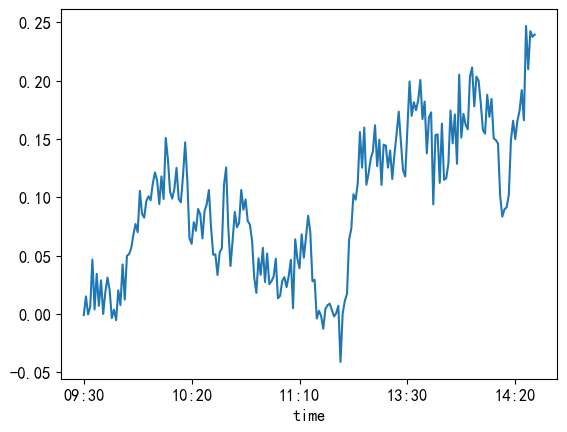

In [17]:
Test_label['pred_htc_ret'] = result
Test_label.index = Test_label['time']
IC = Test_label.groupby([Test_label['Fund_code'],Test_label.index.strftime("%H:%M")]).apply(lambda x:x['htc_ret'].corr(x['pred_htc_ret']))
IC.name = 'IC'
IC = IC.reset_index()
for Fund_code in IC['Fund_code'].drop_duplicates():
    IC_mean = IC[IC['Fund_code']==Fund_code]['IC'].mean()
    IR = IC[IC['Fund_code']==Fund_code]['IC'].mean()/IC[IC['Fund_code']==Fund_code]['IC'].std()
    print(f'{Fund_code}的IC为{IC_mean: .3f},IR为{IR: .3f}')
IC.index = IC['time']
IC[IC['Fund_code']=='F159915.SZ']['IC'].plot()

In [18]:
## 分别读取科创50ETF和创业板ETF的分钟频数据
ETF_minquotes = pd.read_parquet('ETF_minquotes.parquet')
F588080 = ETF_minquotes.loc[ETF_minquotes['windcode'] == '588080.SH']
F159915 = ETF_minquotes.loc[ETF_minquotes['windcode'] == '159915.SZ']
F588080.loc[:,'htc_ret'] = F588080.groupby(F588080.index.date).apply(lambda x:x['close'].iloc[-1]/x['open'].shift(-1)-1).values
F159915.loc[:,'htc_ret'] = F159915.groupby(F159915.index.date).apply(lambda x:x['close'].iloc[-1]/x['open'].shift(-1)-1).values
F588080_Test = F588080.loc[(F588080.index.date >= args.TEST.START_DATE) & (F588080.index.date <= args.TEST.END_DATE)]
F159915_Test = F159915.loc[(F159915.index.date >= args.TEST.START_DATE) & (F159915.index.date <= args.TEST.END_DATE)]

In [ ]:
F588080_Test['pred'] = Test_label[Test_label['Fund_code']=='F588080.SH']['pred_htc_ret']
F159915_Test['pred'] = Test_label[Test_label['Fund_code']=='F159915.SZ']['pred_htc_ret']

F588080_Test['pred'] = F588080_Test['pred'].rolling(480,min_periods=240).rank(pct=True)
F159915_Test['pred'] = F159915_Test['pred'].rolling(480,min_periods=240).rank(pct=True)
#F588080_Test['pred'] = F588080_Test['pred'].rolling(5,min_periods=1).mean()

In [36]:
F588080_Test['pred_upbound'] = F588080_Test['pred'].rolling(480,min_periods=240).mean()+0.5*F588080_Test['pred'].rolling(480,min_periods=240).std()
F588080_Test['pred_lowerbound'] = F588080_Test['pred'].rolling(480,min_periods=240).mean()-0.5*F588080_Test['pred'].rolling(480,min_periods=240).std()


平均持仓时间: 116.708861 分钟
胜率：0.417021
年化收益率：0.041558
年化夏普比率：0.249570


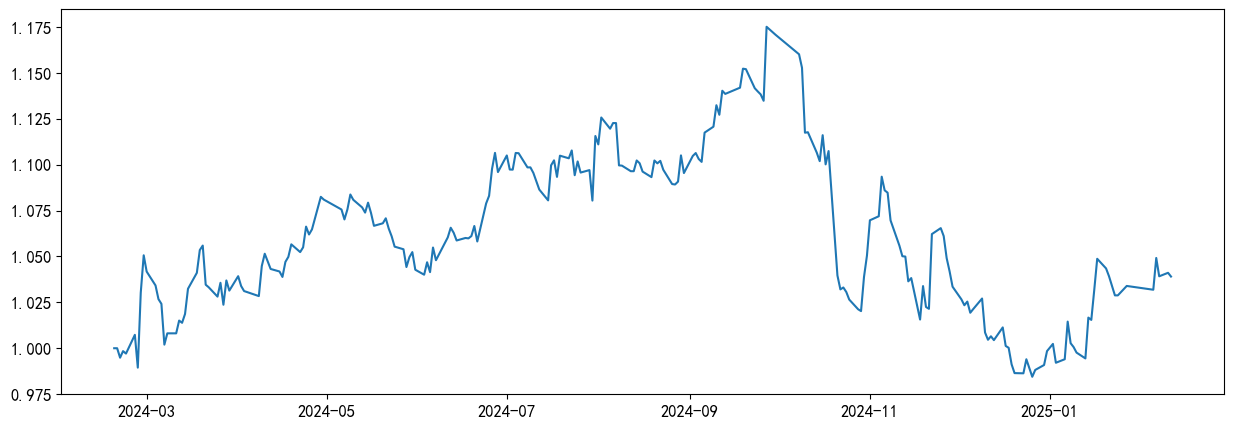

In [37]:
## 未引入止损条件
strategy1 = ETFIntradayStrategy(
    data = F588080_Test,
    factor_name = 'pred',
    LimitOpenTime = '10:00', # 限制10:30以后再开仓
    BuyBound = F588080_Test['pred_upbound'],
    SellBound = F588080_Test['pred_lowerbound']
)
performance = strategy1.get_performance()

In [22]:
Test_label

time   Fund_code  htc_ret  pred_htc_ret
time                                                                      
2024-02-19 09:59:00 2024-02-19 09:59:00  F588080.SH        1      0.445864
2024-02-19 10:00:00 2024-02-19 10:00:00  F588080.SH        1      0.444938
2024-02-19 10:01:00 2024-02-19 10:01:00  F588080.SH        1      0.445312
2024-02-19 10:02:00 2024-02-19 10:02:00  F588080.SH        1      0.444842
2024-02-19 10:03:00 2024-02-19 10:03:00  F588080.SH        1      0.444884
...                                 ...         ...      ...           ...
2025-02-11 14:25:00 2025-02-11 14:25:00  F159915.SZ        0      0.447155
2025-02-11 14:26:00 2025-02-11 14:26:00  F159915.SZ        0      0.450637
2025-02-11 14:27:00 2025-02-11 14:27:00  F159915.SZ        0      0.453421
2025-02-11 14:28:00 2025-02-11 14:28:00  F159915.SZ        0      0.459783
2025-02-11 14:29:00 2025-02-11 14:29:00  F159915.SZ        0      0.465990

[99954 rows x 4 columns]

In [19]:
Fund_temp = F588080
i=30
seq_len = 30
factor_list = ['open','high','low','close','volume']
Fund_temp.iloc[i-seq_len:i][factor_list].rank(axis=0,pct=True).values

array([[0.38333333, 0.3       , 0.1       , 0.06666667, 0.96666667],
       [0.06666667, 0.03333333, 0.05      , 0.03333333, 0.93333333],
       [0.03333333, 0.06666667, 0.05      , 0.1       , 0.73333333],
       [0.1       , 0.13333333, 0.13333333, 0.23333333, 0.66666667],
       [0.28333333, 0.41666667, 0.36666667, 0.5       , 0.86666667],
       [0.53333333, 0.51666667, 0.55      , 0.5       , 0.9       ],
       [0.53333333, 0.51666667, 0.55      , 0.6       , 0.56666667],
       [0.65      , 0.7       , 0.73333333, 0.6       , 0.7       ],
       [0.65      , 0.7       , 0.73333333, 0.7       , 0.83333333],
       [0.73333333, 0.7       , 0.73333333, 0.76666667, 0.5       ],
       [0.78333333, 0.78333333, 0.55      , 0.41666667, 0.76666667],
       [0.46666667, 0.41666667, 0.41666667, 0.41666667, 0.63333333],
       [0.38333333, 0.3       , 0.3       , 0.31666667, 0.8       ],
       [0.38333333, 0.36666667, 0.3       , 0.23333333, 1.        ],
       [0.21666667, 0.21666667, 0.

In [1]:
import torch

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
device

device(type='cuda')

In [2]:
print(torch.__version__)
print(torch.version.cuda)
print(torch.backends.cudnn.version())

2.3.0+cu118
11.8
8700


In [17]:
result

[array([[-0.00104889],
        [-0.00104889],
        [-0.00104889],
        [-0.00104889],
        [-0.00104889],
        [-0.00104889],
        [-0.00104889],
        [-0.00104889],
        [-0.00104889],
        [-0.00104889],
        [-0.00104889],
        [-0.00104889],
        [-0.00104889],
        [-0.00104889],
        [-0.00104889],
        [-0.00104889],
        [-0.00104889],
        [-0.00104889],
        [-0.00104889],
        [-0.00104889],
        [-0.00104889],
        [-0.00104889],
        [-0.00104889],
        [-0.00104889],
        [-0.00104889],
        [-0.00104889],
        [-0.00104889],
        [-0.00104889],
        [-0.00104889],
        [-0.00104889],
        [-0.00104889],
        [-0.00104889],
        [-0.00104889],
        [-0.00104889],
        [-0.00104889],
        [-0.00104889],
        [-0.00104889],
        [-0.00104889],
        [-0.00104889],
        [-0.00104889],
        [-0.00104889],
        [-0.00104889],
        [-0.00104889],
        [-0

## 四、日内动量策略
目前还差一个止损条件

In [1]:
from main import *
ETF_minquotes = pd.read_parquet(f'ETF_minquotes.parquet')
F588080 = ETF_minquotes.loc[ETF_minquotes['windcode'] == '588080.SH']
F159915 = ETF_minquotes.loc[ETF_minquotes['windcode'] == '159915.SZ']

def GetMomBound(minquote):
    """计算动量策略的上下限"""
    minquote.loc[:,'open0930'] = minquote.groupby(minquote.index.date)['open'].transform(lambda x: x.iloc[0])  # 0930开盘价
    minquote.loc[:,'move'] = (minquote['close']/minquote['open0930']-1).abs()  # 计算每分钟的价格位移
    minquote.loc[:,'move_rolling10'] = minquote.groupby(minquote.index.strftime('%H:%M'))['move'].transform(lambda x: x.rolling(10,min_periods=5).mean())
    minquote.loc[:,'close_last'] = (minquote.groupby(minquote.index.date)['close'].transform(lambda x: x.iloc[-1])).shift(240)  # 前一日收盘价
    minquote.loc[:,'upper_bound'] = minquote[['open0930','close_last']].max(axis=1)*(1+minquote['move_rolling10'])  # 计算上限
    minquote.loc[:,'lower_bound'] = minquote[['open0930','close_last']].min(axis=1)*(1-minquote['move_rolling10'])  # 计算下限
    return minquote

F159915 = GetMomBound(F159915)
F588080 = GetMomBound(F588080)

平均持仓时间: 166.169655 分钟
胜率：0.587276
年化收益率：0.820287
年化夏普比率：4.594567


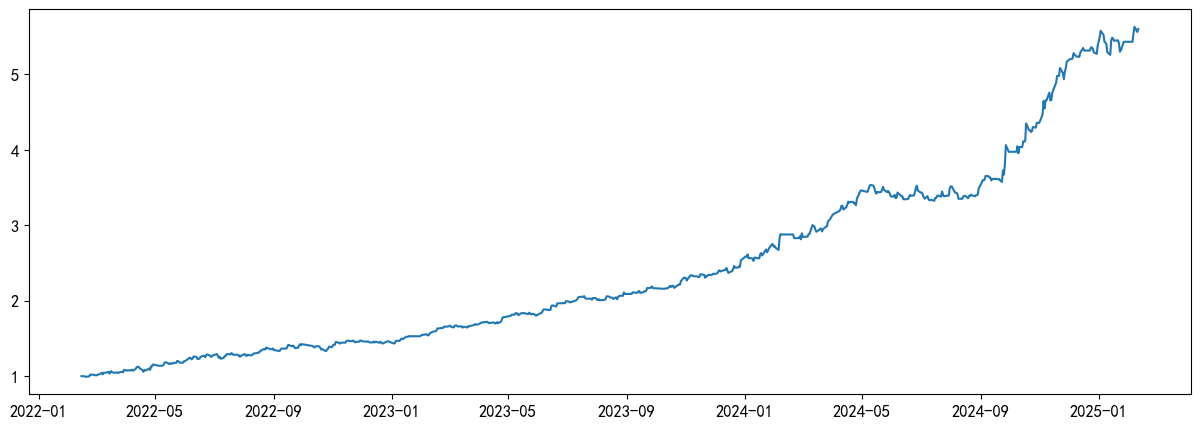

In [2]:
strategy = ETFIntradayStrategy(
    data=F159915,
    factor_name = 'close',
    direction = 1,
    periods = [('09:30','15:00')],
    rolling_is_rank = True,
    rolling_window = 480,
    bound_is_series = True,
    upper_bound = F159915['upper_bound'],
    lower_bound = F159915['lower_bound'],
    upper_stop_bound = F159915['lower_bound'],
    lower_stop_bound = F159915['upper_bound'],
    stop_loss_ratio = 0.02
)
daily_performance = strategy.get_performance()

平均持仓时间: 167.263448 分钟
胜率：0.527473
年化收益率：0.510711
年化夏普比率：2.579159


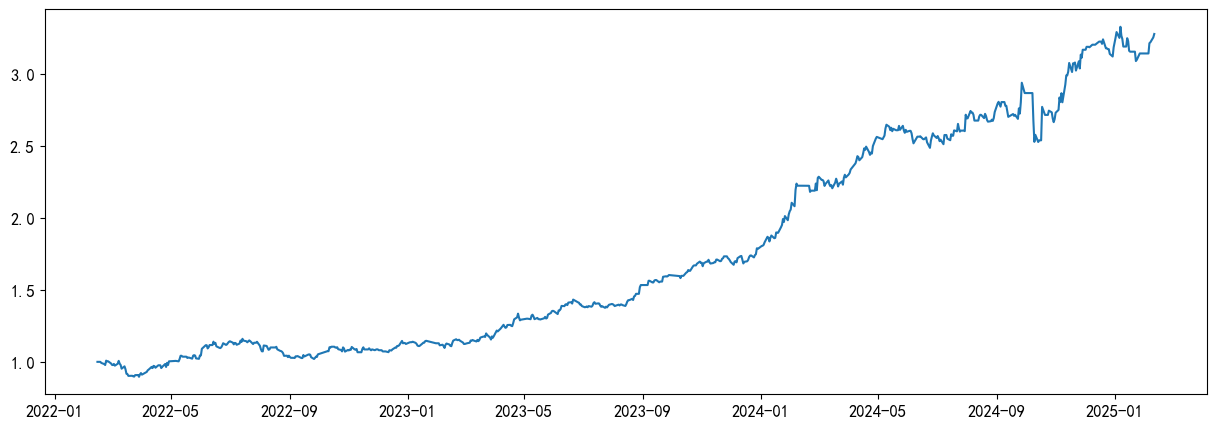

In [4]:
strategy = ETFIntradayStrategy(
    data=F588080,
    factor_name = 'close',
    direction = 1,
    periods = [('09:30','15:00')],
    rolling_is_rank = True,
    rolling_window = 480,
    bound_is_series = True,
    upper_bound = F588080['upper_bound'],
    lower_bound = F588080['lower_bound'],
    upper_stop_bound = F588080['lower_bound'],
    lower_stop_bound = F588080['upper_bound'],
    stop_loss_ratio = 0.02
)
daily_performance = strategy.get_performance()

平均持仓时间: 130.820690 分钟
胜率：0.548446
年化收益率：0.377369
年化夏普比率：2.076234


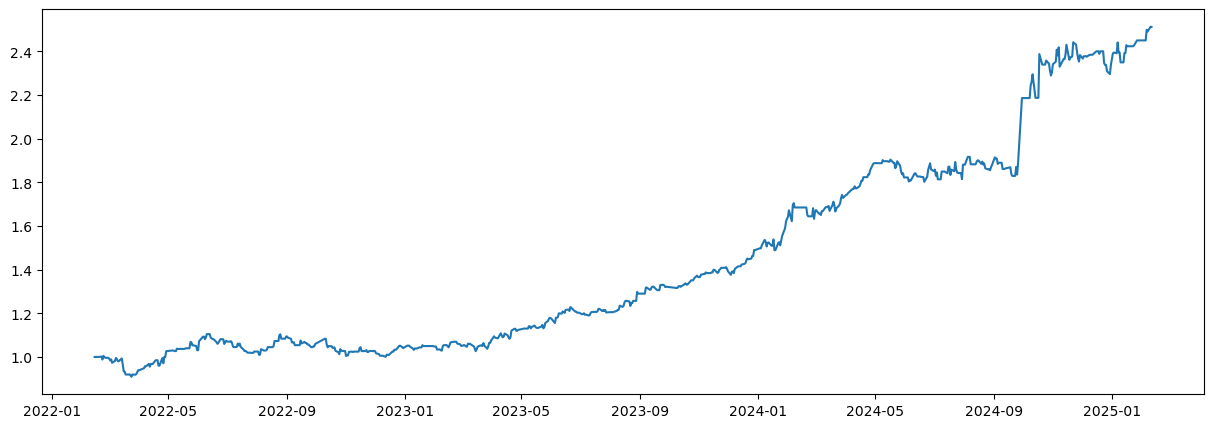

In [ ]:
## 未引入止损条件
strategy1 = ETFIntradayStrategy(
    data = F588080,
    factor_name = 'close',
    LimitOpenTime = '10:00', # 限制10:30以后再开仓
    BuyBound = F588080['upper_bound'],
    SellBound = F588080['lower_bound']
)
performance = strategy1.get_performance()

平均持仓时间: 123.628966 分钟
胜率：0.586074
年化收益率：0.607347
年化夏普比率：3.685418


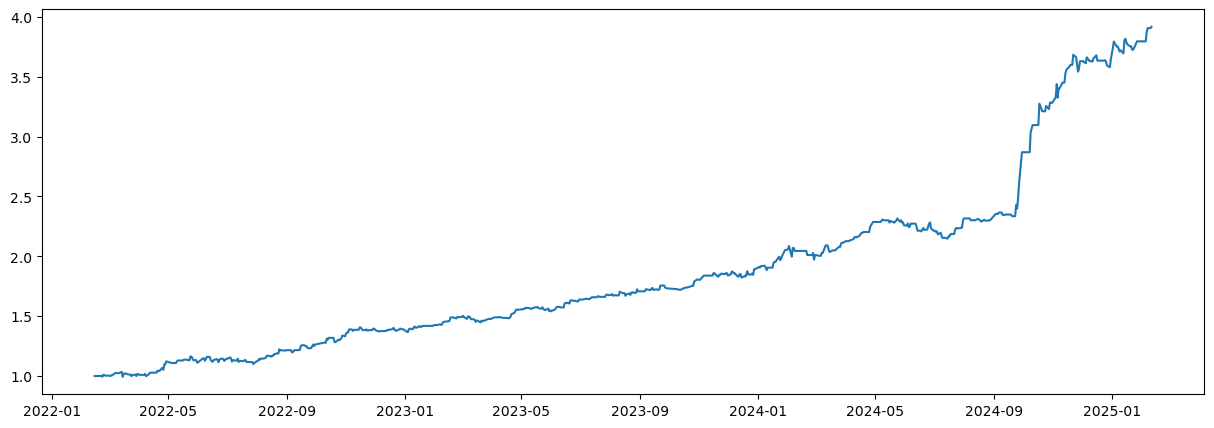

In [ ]:
## 未引入止损条件
strategy1 = ETFIntradayStrategy(
    data = F159915,
    factor_name = 'close',
    LimitOpenTime = '10:00', # 限制10:30以后再开仓
    BuyBound = F159915['upper_bound'],
    SellBound = F159915['lower_bound']
)
performance = strategy1.get_performance()